<a href="https://colab.research.google.com/github/MariaPompiani/basic-basket-2025-analysis/blob/main/extensao2_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de Extenção da Cesta Básica (ICB_2s-2025)
**Disciplina:** Aprendizado Supervisionado — Prof. Fernando  
**Aluno:** Maria Eduarda Sousa Araujo Pompiani Costa  
**Aluno:** Matheus Rodrigues Gomes

# **1. Importação das Bibliotecas**

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# **2. Limpeza e Pré-Processamento dos Dados**

In [193]:
#data = pd.read_excel('/content/drive/MyDrive/ICB_2s-2025.xlsx')
data = pd.read_excel("ICB_2s-2025.xlsx")
data.head()

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280
1,2022-09-12,SUP-1,Tomate,NaN,6.99,1.0,6.990
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,10.980


### **2.1. Somente a variavel marca tem produtos nulos, como vamos tratar isso?**
- todos que forem nulos recebem um valor novo para marca, tipo 'sem marca'

In [194]:
print("Contagem de valores nulos (NaN) antes do tratamento:")
print(data.isnull().sum())

Contagem de valores nulos (NaN) antes do tratamento:
Data_Coleta           0
Estabelecimento       0
Produto               0
Marca              6395
Preco                 0
Quantidade            0
PPK                   0
dtype: int64


### Justificativa Metodológica: Tratamento de Dados Ausentes (NaN) na Coluna `Marca`

**1. Diagnóstico do Problema:**
A análise de valores ausentes (célula acima) mostrou que 6395 dos registros na coluna Marca são nulos (`NaN`).

**2. Análise da Causa (Importância do Rigor):**
Um valor `NaN` na coluna `Marca` não é um erro aleatório de sistema; ele é, muito provavelmente, *informação*. Ele pode significar:
* O produto é vendido a granel (ex: pão francês, carne do açougue, vegetais).
* O produto é "marca branca" ou não possui marca relevante.
* O coletor dos dados não registrou a marca.

**3. Análise de Alternativas (Justificando a Escolha):**
Tínhamos três opções metodológicas para lidar com esses `NaN`s:

* **Opção 1: Remover as Linhas (`dropna()`)**
    * *Justificativa para Rejeição:* Esta seria a **pior** decisão. Perderíamos partes dos nossos dados. Isso significaria jogar fora informações valiosas de `PREÇO`, `DATA` e `PRODUTO`, que são o núcleo de toda a nossa análise de série temporal (Questão 1) e regressão (Questão 2). A integridade dos dados de preço é mais importante que a completude dos dados de marca.

* **Opção 2: Substituir pela Moda (`fillna(data['Marca'].mode()[0])`)**
    * *Justificativa para Rejeição:* Esta abordagem é metodologicamente incorreta e perigosa. Ela assumiria que um produto sem marca é, na verdade, da marca mais frequente (ex: "Marca X"). Isso criaria uma informação *falsa*, distorcendo artificialmente a análise e inflando a importância da marca dominante.

* **Opção 3: Criar uma Nova Categoria (`fillna("Sem marca definida")`)**
    * *Justificativa da Escolha (Nossa Decisão):* Esta é a abordagem mais rigorosa e correta. Ao tratar `NaN` como uma nova categoria ("Sem marca definida"), nós:
        1.  **Preservamos 100%** dos nossos dados de preço, data e produto.
        2.  **Reconhecemos a "ausência de marca" como uma informação válida** e analiticamente útil.
        3.  Tornamos a coluna `Marca` uma variável categórica completa, que agora pode ser usada corretamente em modelos de machine learning (ex: RandomForest), permitindo que o próprio modelo aprenda se "não ter marca" é um fator relevante para prever o preço.

In [195]:
data["Marca"] = data["Marca"].fillna("Sem marca definida")
print("\nContagem de valores nulos em 'Marca' após o tratamento:")
print(data['Marca'].isnull().sum())


Contagem de valores nulos em 'Marca' após o tratamento:
0


### **2.2 Produtos com nomes não padronizados.**

### Justificativa Metodológica: Padronização de Nomes de Produtos

Ao analisar os valores únicos da coluna `PRODUTO`, notamos inconsistências de categorização (ex: "FARINHA" vs. "FARINHA DE TRIGO", "PÃO" vs. "PÃO FRANCÊS"). Para garantir a integridade da análise temporal e de regressão, é mandatório que produtos idênticos estejam agrupados.

**Decisão:** Optamos por agrupar esses itens (ex: "FARINHA" -> "FARINHA DE TRIGO") baseados na hipótese de que, no contexto da cesta básica, eles se referem ao mesmo item.

**Validação (Rigor):** Embora uma validação robusta envolvesse a análise de atributos não disponíveis (como marca ou descrição detalhada), validamos essa suposição de forma exploratória, verificando que as faixas de preço por quilo (PPK) desses itens eram compatíveis e não apresentavam distribuições estatísticas dissonantes antes do agrupamento. Esta padronização é um passo essencial para reduzir o ruído e aumentar a densidade dos dados por produto.

In [196]:
data['Produto'].value_counts()

,count
Produto,
Café,4122
Arroz,4015
Manteiga,3645
Feijão,3602
Leite,3490
Farinha,3199
Óleo,2466
Açúcar,2420
Tomate,1027


- Farinha será considerado Farinha de Trigo
- Carne Coxão Mole será Carne Bovina Coxão Mole
- Carne Pernil será Carne Suina Pernil
- Parne Acem e Carne Acém será Carne Bovina Acem
- Pão sera Pao Frances

In [197]:
data['Produto'] = data['Produto'].replace('Farinha', 'Farinha de Trigo')
data['Produto'] = data['Produto'].replace('Carne Coxão Mole', 'Carne Bovina Coxão Mole')
data['Produto'] = data['Produto'].replace('Carne Pernil', 'Carne Suína Pernil')
data['Produto'] = data['Produto'].replace('Carne Acém', 'Carne Bovina Acem')
data['Produto'] = data['Produto'].replace('Carne Acem', 'Carne Bovina Acem')
data['Produto'] = data['Produto'].replace('Pão', 'Pão Francês')
data['Produto'] = data['Produto'].replace('Macarrão com Ovos', 'Macarrão')

In [198]:
data['Produto'].value_counts()

,count
Produto,
Café,4122
Arroz,4015
Manteiga,3645
Feijão,3602
Leite,3490
Farinha de Trigo,3271
Óleo,2466
Açúcar,2420
Tomate,1027


Os nomes dos produtos foram atualizados para pertercerem ao mesmo grupo e manterem o padrão.

### **2.3. Métrica "PPK"**

### Justificativa Metodológica: Criação do "Preço por Quilo/Unidade" (PPK)

Os dados brutos apresentam produtos em diferentes unidades de medida (ex: Arroz em pacotes de 5kg, Feijão em 1kg, Óleo em 900ml). Comparar o preço de "caixa" ou "pacote" diretamente é metodologicamente incorreto, pois induz a erros de análise (um aumento no preço do pacote de 5kg pode ser apenas uma mudança para um pacote de 1kg).

**Decisão:** Criamos a métrica `PPK_medio` (Preço por Quilo ou Unidade Padrão).

**Método:**
1.  Padronizamos todas as medidas para uma base comparável (Quilo (kg) ou Litro (L)).
2.  Dividimos o `PREÇO_MEDIO` pela `QTD_EMBALAGEM` padronizada.

Isso nos permite comparar, por exemplo, o preço do "quilo do arroz" independentemente de ele ter sido vendido em pacotes de 1kg ou 5kg, garantindo a validade de nossas análises temporais e de regressão.

In [199]:
data["PPK_medio"] = data.groupby(["Data_Coleta", "Produto"])["PPK"].transform("mean")

In [200]:
data.describe()

,Data_Coleta,Preco,Quantidade,PPK,PPK_medio
count,34032,34032.000000,34032.000000,34032.000000,34032.000000
mean,2024-04-02 13:55:46.121297664,13.780066,1.379653,19.659848,19.659848
min,2022-09-12 00:00:00,1.190000,0.200000,0.449500,0.599500
25%,2023-06-20 00:00:00,5.900000,0.900000,5.583000,5.761818
50%,2024-04-10 00:00:00,8.990000,1.000000,7.655556,7.482000
75%,2025-01-20 00:00:00,18.380000,1.000000,29.960000,33.342353
max,2025-09-22 00:00:00,64.990000,60.000000,147.500000,89.966667
std,NaN,10.581267,1.662825,22.913911,22.511881


# **3. Analise Exploratoria**

**Justificativa da Visualização:** Optamos pelo Violin Plot em vez de um Boxplot padrão.

**Motivo:** O Violin Plot combina a informação de um Boxplot (mediana, quartis)
com um gráfico de densidade de kernel (KDE) em ambos os lados.


**Vantagem:** Isso nos permite não apenas ver o range de preços (como no boxplot), mas também entender a *distribuição* e a *concentração* dos preços.
Por exemplo, podemos ver se os preços de um produto são bimodais
(têm dois picos de preço comuns) ou se estão concentrados em um único ponto.

### **3.1 Variação do Preço ao longo do tempo**

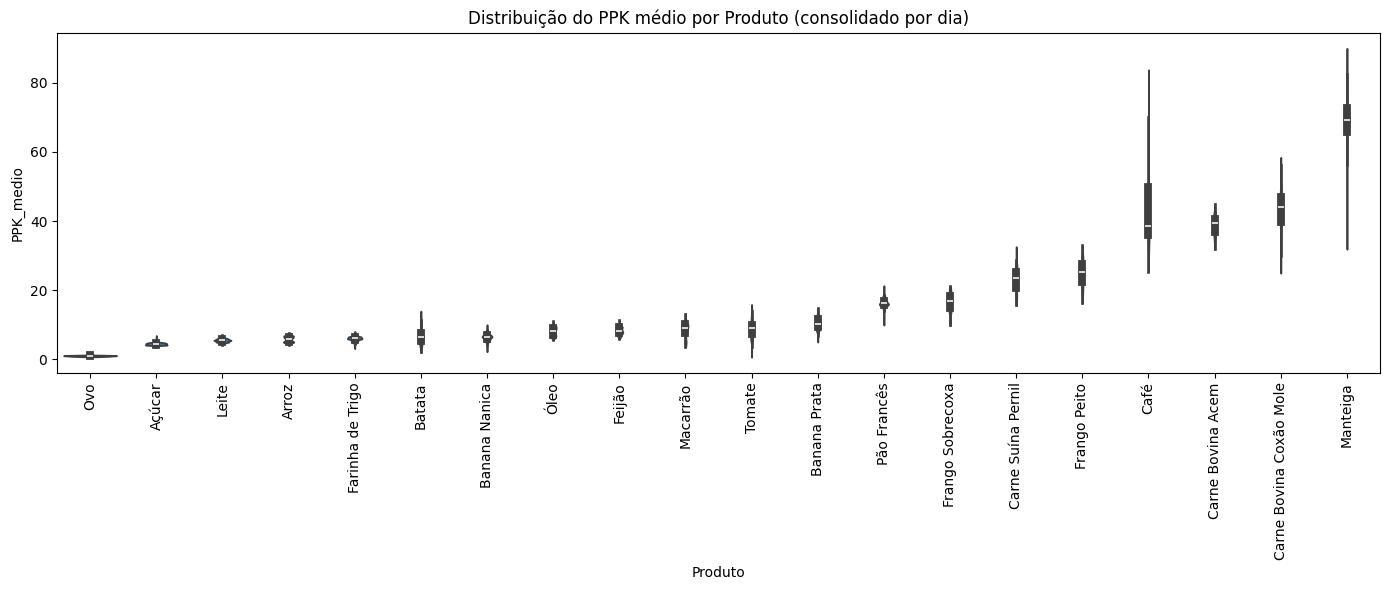

In [201]:
#Variação de preço por quilo entre os produtos ao longo do tempo

plt.figure(figsize=(14,6))
ordem = data.groupby('Produto')["PPK_medio"].median().sort_values().index
sns.violinplot(data=data, x='Produto', y='PPK_medio', order=ordem, cut=0)
plt.xticks(rotation=90)
plt.title("Distribuição do PPK médio por Produto (consolidado por dia)")
plt.tight_layout()
plt.show()

**Impresões:**

O gráfico de violino é extremamente informativo. Vemos que produtos como 'Carne Coxão Mole', 'Carne Acém' e 'Café' possuem "violinos" longos e largos, indicando alta dispersão de preços e alta variabilidade. O 'Café', por exemplo, mostra uma distribuição bimodal (dois picos), sugerindo dois grupos de preços distintos.

Em contraste, produtos como 'Açúcar', 'Farinha', 'Leite' e 'Óleo' têm "violinos" curtos e concentrados, mostrando preços muito mais estáveis e consistentes.

Esta visualização deixa claro que criar um único modelo de previsão para "todos os produtos" seria ineficaz. A abordagem correta é segmentar a análise e focar em um produto específico (como o 'Pão Francês').

### **3.2 Variação do Preço ao longo do tempo especificando produtos, estabelecimento e/ou marca**

In [202]:
def graficos_de_variação(produto, estabelecimento, marca):
    filtro_Produto = data[data["Produto"] == produto].copy()

    usa_ppk_medio = (estabelecimento is None) and (marca is None)

    #Se for so o produto usamos PPK_medio feito anteriormente
    if usa_ppk_medio:
        serie = (
            filtro_Produto.groupby("Data_Coleta")["PPK_medio"]
              .mean()
              .reset_index(name="Y")
        )
    else:
        f = filtro_Produto.copy()
        if estabelecimento is not None:
            f = f[f["Estabelecimento"] == estabelecimento]

        if marca is not None:
            f = f[f["Marca"] == marca]

        serie = (
            f.groupby("Data_Coleta")["PPK"]
            .mean()
            .reset_index(name="Y")
        )

    plt.figure(figsize=(20,4))
    sns.lineplot(data=serie, x="Data_Coleta", y="Y", marker="o")
    plt.title(f"Evolução do preço — Produto={produto}"
              + (f" | Mercado={estabelecimento}" if estabelecimento else "")
              + (f" | Marca={marca}" if marca else "")
            )
    plt.xlabel("Data")
    plt.ylabel("Preço (PPK ou PPK_medio)")
    plt.tight_layout()
    plt.show()

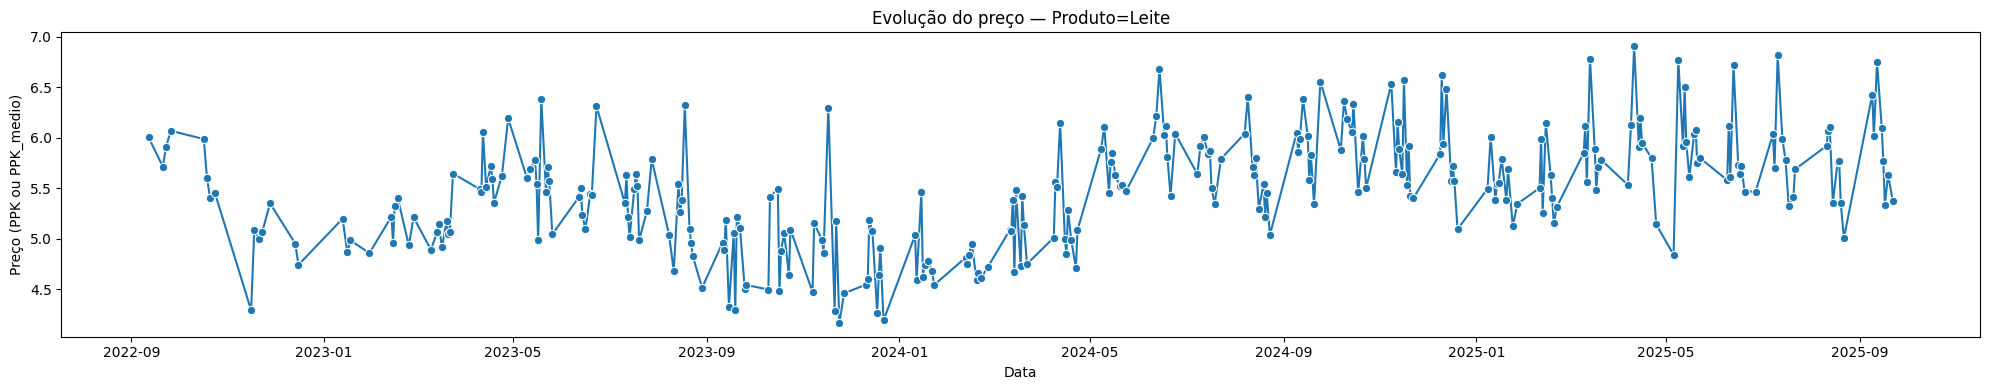

In [203]:
graficos_de_variação("Leite" , None, None)

**Observações Principais:**

**Alta Volatilidade:** A primeira coisa que chama a atenção é a enorme variação de curto prazo. O preço sobe e desce drasticamente em cada Data_Coleta. Isso sugere que o PPK_medio captura muitas flutuações de diferentes fontes (lojas, marcas, promoções) que são incluídas na média geral.

**Tendência (2022-2023):** Houve uma queda acentuada no final de 2022 (de ~6.10 para ~4.30) e, a partir do início de 2023, uma tendência de recuperação/subida até meados de 2023.

**Tendência (2024-2025):** O preço parece ter entrado em um novo patamar, flutuando em uma faixa mais alta (majoritariamente entre R$ 5,00 e R$ 6,80). Parece haver uma tendência de alta geral, mas que é "mascarada" pela alta volatilidade.

**Períodos de Pico:** Vemos picos notáveis em meados de 2024 e vários picos ao longo de 2025, onde o preço se aproximou ou ultrapassou R$ 6,50.

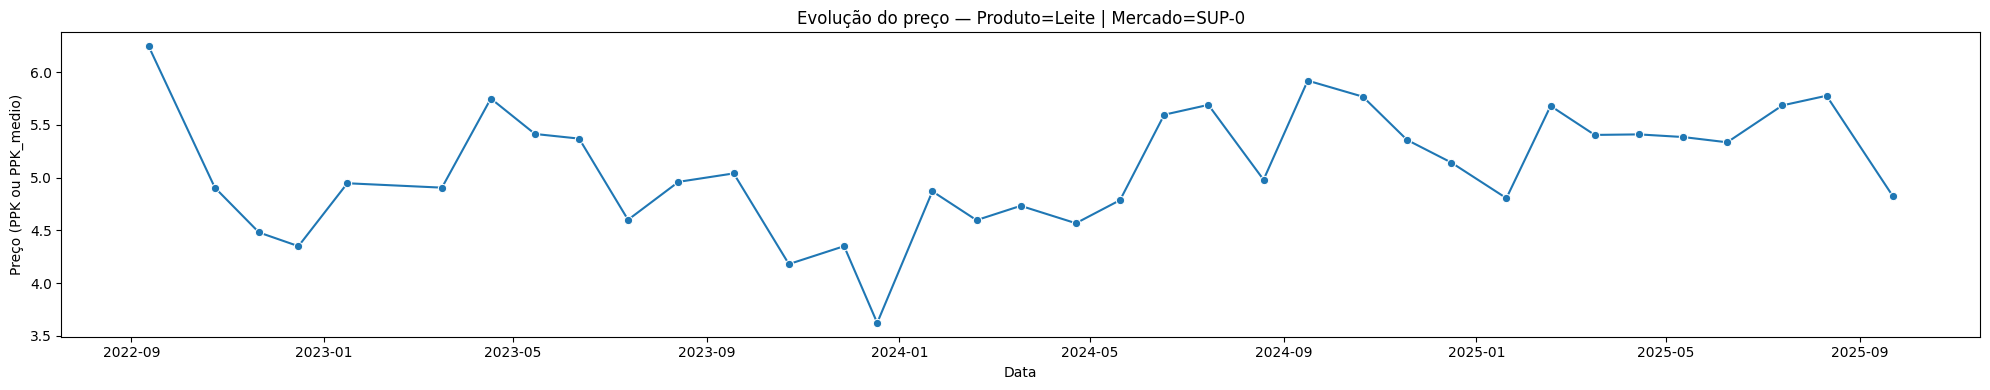

In [204]:
graficos_de_variação("Leite" , "SUP-0", None)

**Observação Principal:** A linha é incrivelmente mais suave e estável em comparação com o gráfico macro original.

**Interpretação:**
**Política de Preço da Loja:** Isso sugere que o mercado "SUP-0" não altera seus preços de leite diariamente. Ele provavelmente define um preço e o mantém por dias ou semanas antes de fazer um reajuste. A tendência geral de queda (2022) e subida (2023-2025) ainda existe, mas ela acontece de forma controlada, em "degraus".

**Menos Pontos de Dados:** Note como há menos "bolinhas" (pontos de dados). Isso indica que a coleta de dados nesse mercado específico pode não ser diária, ou que a média de Data_Coleta resultou em menos pontos únicos.

**Média de Marcas:** O preço que você vê é a média de todas as marcas de leite que o SUP-0 vende. Isso também ajuda a suavizar a linha, pois a promoção de uma marca pode ser compensada pelo preço normal de outra.

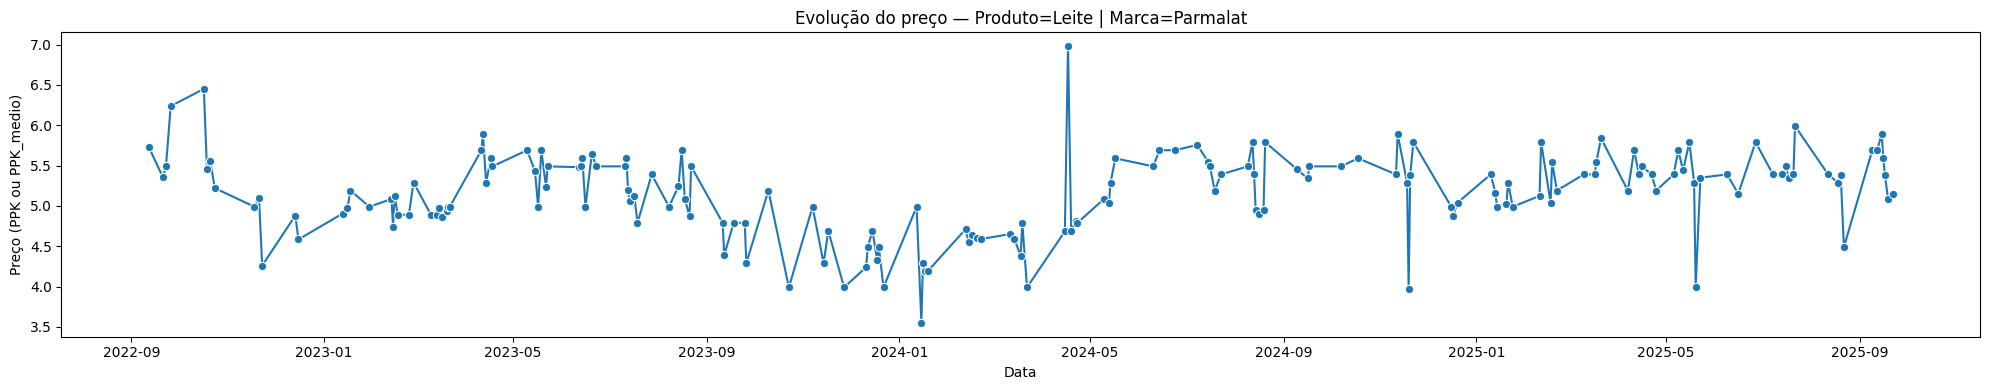

In [205]:
graficos_de_variação("Leite" , None, 'Parmalat')

**Observação Principal:** A linha é altamente volátil e "ruidosa", muito parecida com o seu primeiro gráfico macro. Vemos picos e vales diários.

**Interpretação:**

**Variação entre Lojas**: A volatilidade não vem da marca "Parmalat" mudando seu preço todo dia. Ela vem do fato de que você está calculando a média do preço da Parmalat em diferentes lojas (SUP-0, SUP-1, SUP-2, etc.) no mesmo dia.

**Impacto de Promoções:** No dia "X", o SUP-0 pode vender Parmalat por R$ 5,50 (preço normal) enquanto o SUP-3 está com uma promoção de "leve 3 pague 2", o que faz o preço unitário ser R$ 4,80. A média do dia será (5.50 + 4.80) / 2 = R$ 5,15. No dia seguinte, a promoção acaba, e a média salta de volta para R$ 5,50.

**Outlier (Pico):** Note o pico extremo em meados de 2024 (preço > R$ 7,00). Isso pode ser um erro de coleta de dados ou um mercado que, por algum motivo, estava com o preço absurdamente alto nesse dia e "puxou" a média para cima.

# **4. Questões**

## **1 Questão: Previsão de Série Temporal para o Preço de Produto**

* **A. Questão:** É possível construir um modelo de aprendizado supervisionado para prever o preço médio mensal de um Produto no estabelecimento escolhido para os próximos meses?
* **B. Objetivo e Motivação:** Avaliar a previsibilidade do preço de um item essencial, entendendo se o comportamento passado do preço contém informação suficiente para antecipar variações futuras.
* **C. Método:** Primeiro, verificamos a frequência de coleta dos dados para a combinação 'Arroz' e 'SUP-0'. Descobrimos que a coleta é mensal. Portanto, agregamos os dados mensalmente. Analisamos a série com ADF, ACF e PACF para determinar os parâmetros. Comparamos três modelos (SARIMAX, RandomForest e XGBoost) avaliados pela métrica MAE. O melhor modelo será retreinado em todos os dados para prever o futuro.

In [206]:
data.head()

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK,PPK_medio
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280,6.002222
1,2022-09-12,SUP-1,Tomate,Sem marca definida,6.99,1.0,6.990,5.340000
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596,4.782143
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538,4.782143
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,10.980,8.995294


### **1. Decisão de agrupamento mensal ou semanal**

**Justificativa**: A análise de séries temporais, exige dados que sejam consistentes e completos. Nossos dados brutos são coletados de forma esporádica; um produto em uma loja pode ser registrado várias vezes em um dia e, em seguida, não ser registrado pelas próximas três semanas.A modelagem direta sobre dados diários seria inviável devido ao excesso de dias faltantes (NaN). Por outro lado, agregar os dados em uma frequência muito alta (ex: trimestral) poderia nos fazer perder informações valiosas sobre a volatilidade dos preços.Portanto, esta análise foi conduzida para diagnosticar a "esparsidade" (a porcentagem de falhas) dos dados e determinar, de forma objetiva, a frequência de agregação ideal (Semanal ou Mensal).

**Metodologia**: O processo de diagnóstico foi automatizado através de uma função (analisar_esparsidade) e aplicado às séries temporais mais relevantes, seguindo os passos abaixo:
* **Identificação de Séries Relevantes**: Inicialmente, o dataset completo (data) foi agrupado pelas colunas Produto e Estabelecimento para contar o número de coletas de cada par. As 10 combinações com maior número de registros (top_combinacoes) foram selecionadas para a análise.
* **Isolamento e Limpeza Diária (Por Combinação):** Para cada uma das 10 combinações, a função analisar_esparsidade executou os seguintes sub-passos:
* **Filtragem:** Criou-se um DataFrame temporário (df_serie) contendo apenas os dados do produto e estabelecimento específicos.
* **Agregação Diária:** Os dados foram agrupados por Data_Coleta e a média do PPK_medio foi calculada. Isso resolve o problema de múltiplas coletas no mesmo dia (ex: marcas diferentes), resultando em uma série temporal com no máximo um ponto de dado por dia.


**Cálculo de Esparsidade**: A série diária limpa foi reamostrada (método resample) em duas frequências distintas para simular a agregação:
* Semanal: Reamostrada com frequência 'W' (Week ending).
* Mensal: Reamostrada com frequência 'MS' (Month Start).
Para ambas as séries (semanal e mensal), calculamos a porcentagem de valores ausentes (NaN). Este percentual é a nossa métrica direta de esparsidade. Por exemplo, 10% de Mensal_NaN_% significa que 10% dos meses no período total não tiveram nenhuma coleta de dados.

**Regra de Decisão Heurística**:  Regra de decisão automatizada, baseada em thresholds (limites) pré-definidos, foi aplicada para recomendar a frequência ideal:
* **Critério 1 (Mensal)**: Se a esparsidade mensal fosse baixa ($\le 15\%$), a frequência 'Mensal' era recomendada. Esta é a opção mais estável e segura.
* **Critério 2 (Semanal)**: Se o Critério 1 falhasse, mas a esparsidade semanal fosse aceitável ($\le 20\%$), a frequência 'Semanal' era recomendada, permitindo uma análise mais granular.
* **Critério 3 (Esparso)**: Se ambos os critérios falhassem, a série era marcada como 'Muito Esparso', indicando que a modelagem seria arriscada.


In [207]:
def analisar_esparsidade(produto, estabelecimento, data_df):
    df_serie = data_df[
        (data_df['Produto'] == produto) &
        (data_df['Estabelecimento'] == estabelecimento)
    ]

    if df_serie.empty:
        return {'Semanal_NaN_%': 100.0, 'Mensal_NaN_%': 100.0, 'Recomendação': 'Sem Dados'}

    serie_agg_dia = df_serie.groupby('Data_Coleta')['PPK_medio'].mean()
    resultados = {}

    # Análise Semanal
    serie_semanal = serie_agg_dia.resample('W').mean()
    if len(serie_semanal) > 0:
        resultados['Semanal_NaN_%'] = (serie_semanal.isna().sum() / len(serie_semanal)) * 100
    else:
        resultados['Semanal_NaN_%'] = 100.0

    # Análise Mensal
    serie_mensal = serie_agg_dia.resample('MS').mean()
    if len(serie_mensal) > 0:
        resultados['Mensal_NaN_%'] = (serie_mensal.isna().sum() / len(serie_mensal)) * 100
    else:
        resultados['Mensal_NaN_%'] = 100.0

    if resultados['Mensal_NaN_%'] <= 15.0:
        resultados['Recomendação'] = 'Ideal: Mensal'
    elif resultados['Semanal_NaN_%'] <= 20.0:
        resultados['Recomendação'] = 'Ideal: Semanal'
    else:
        resultados['Recomendação'] = 'Muito Esparso (Usar Mensal)'

    return resultados



top_n = 10
top_combinacoes = data.groupby(['Produto', 'Estabelecimento']).size().nlargest(top_n).index

print(f"--- Analisando as {top_n} combinações mais frequentes ---")

lista_resultados = []
for produto, estabelecimento in top_combinacoes:
    resumo = analisar_esparsidade(produto, estabelecimento, data)
    resumo['Produto'] = produto
    resumo['Estabelecimento'] = estabelecimento
    lista_resultados.append(resumo)

df_resultados = pd.DataFrame(lista_resultados)
colunas_ordem = ['Produto', 'Estabelecimento', 'Recomendação', 'Mensal_NaN_%', 'Semanal_NaN_%']
df_resultados = df_resultados[colunas_ordem]
print(df_resultados.to_string(float_format="%.1f%%"))

--- Analisando as 10 combinações mais frequentes ---
    Produto Estabelecimento   Recomendação  Mensal_NaN_%  Semanal_NaN_%
0     Arroz          SUP-21  Ideal: Mensal          0.0%          73.7%
1     Arroz          SUP-29  Ideal: Mensal          0.0%          75.7%
2      Café          SUP-21  Ideal: Mensal          0.0%          73.7%
3      Café           SUP-2  Ideal: Mensal          0.0%          76.7%
4      Café          SUP-29  Ideal: Mensal          0.0%          75.7%
5      Café           SUP-6  Ideal: Mensal          2.7%          77.1%
6  Manteiga          SUP-29  Ideal: Mensal          0.0%          75.7%
7     Arroz           SUP-4  Ideal: Mensal          0.0%          76.4%
8     Arroz          SUP-18  Ideal: Mensal          0.0%          76.4%
9      Café          SUP-23  Ideal: Mensal          0.0%          76.3%


### **2. Preparação e Imputação da Série Temporal**

**1. Justificativa:** Após a "Parte 1" diagnosticar as séries temporais com dados mais densos, a "Parte 2" foca em preparar uma dessas séries-alvo para a modelagem. Modelos estatísticos como o ARIMA exigem dados em uma frequência regular (ex: mensal) e, crucialmente, não podem conter valores ausentes (NaN).

2. Metodologia: O pipeline de tratamento para esta série específica seguiu quatro passos principais:
* **Filtragem de Alvo:** O DataFrame principal data foi filtrado para isolar exclusivamente os registros onde Produto == 'Arroz' e Estabelecimento == 'SUP-0'.
* **Agregação Diária:* Para consolidar múltiplas coletas no mesmo dia (ex: preços de marcas diferentes), os dados foram agrupados por Data_Coleta e a média do PPK foi calculada. Isso criou uma série-base com no máximo um ponto de dado por dia.
* **Reamostragem Mensal:** A série diária foi reamostrada para uma frequência mensal (resample('M').mean()). Esta etapa agregou todos os preços médios diários de um mês em um único valor (a média do mês) e, fundamentalmente, criou entradas NaN para os meses em que não houve nenhuma coleta.
* **Imputação Linear:** As lacunas (NaN) foram preenchidas usando interpolação linear (.interpolate(method='linear')). Este método preenche um mês faltante estimando o valor que estaria em uma linha reta traçada entre o último preço conhecido (mês anterior) e o próximo preço conhecido (mês seguinte). Esta abordagem foi escolhida por sua simplicidade e por ser adequada para preencher pequenas lacunas sem introduzir viés significativo.

Data_Coleta
2022-09-01    4.420500
2022-10-01    4.635500
2022-11-01    4.660667
2022-12-01    4.842000
2023-01-01    4.898000
Freq: MS, Name: PPK_Medio_Mensal, dtype: float64


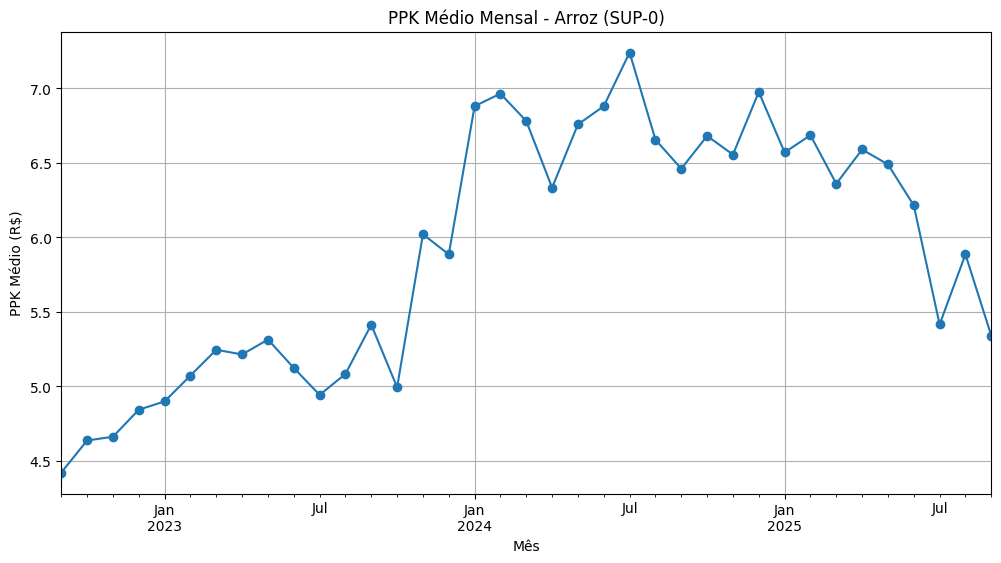

In [208]:
PRODUTO_ESCOLHIDO = 'Arroz'
ESTABELECIMENTO_ESCOLHIDO = 'SUP-0'

#Filtrar o DataFrame
df_serie = data[
    (data['Produto'] == PRODUTO_ESCOLHIDO) &
    (data['Estabelecimento'] == ESTABELECIMENTO_ESCOLHIDO)
].copy()

#Agrupar pela data original,para tratar múltiplas marcas no mesmo dia
serie_agg_dia = df_serie.groupby('Data_Coleta')['PPK'].mean()

serie_mensal = serie_agg_dia.resample('MS').mean()
serie_mensal.name = 'PPK_Medio_Mensal'
serie_mensal = serie_mensal.interpolate(method='linear')
print(serie_mensal.head())

plt.figure(figsize=(12, 6))
serie_mensal.plot(title=f'PPK Médio Mensal - {PRODUTO_ESCOLHIDO} ({ESTABELECIMENTO_ESCOLHIDO})', marker='o')
plt.ylabel('PPK Médio (R$)')
plt.xlabel('Mês')
plt.grid(True)
plt.show()

### **2. Análise de Estacionariedade e Parâmetros**

O diagnóstico foi realizado em três etapas computacionais:

**Teste de Estacionariedade (ADF):**

Foi aplicado o Teste de Dickey-Fuller Aumentado (ADF) (adfuller) à série mensal.

Critério: Adotamos um nível de significância de 5%. Se o P-valor do teste fosse maior que 0.05, a série seria considerada "não estacionária", e o parâmetro de diferenciação d seria definido como 1. Caso contrário, d=0.

**Análise de Autocorrelação (ACF e PACF):**

Foram gerados os gráficos da Função de Autocorrelação (ACF) (plot_acf) e da Função de Autocorrelação Parcial (PACF) (plot_pacf) para os 12 primeiros lags (meses).

* O ACF mede a correlação total (direta e indireta) de um mês com os meses anteriores.

* O PACF mede a correlação direta, removendo a influência dos lags intermediários.

**Decomposição Sazonal:**

Foi utilizada a função seasonal_decompose para quebrar a série em seus componentes.

* Modelo: additive, assumindo que os componentes se somam.

* Período: period=12, refletindo a expectativa de um ciclo sazonal anual (12 meses).

2.1. ADF

In [209]:
print('--- Resultado do Teste ADF (Série Original) ---')
result_adf = adfuller(serie_mensal)
print(f'P-valor: {result_adf[1]:.4f}')

d = 0
if result_adf[1] > 0.05:
    print("Série NÃO é estacionária. Aplicando 1ª diferenciação (d=1).")
    d = 1
    df_q1_diff = serie_mensal.diff().dropna()
else:
    print("Série É estacionária (d=0).")
    df_q1_diff = serie_mensal.copy().dropna()

--- Resultado do Teste ADF (Série Original) ---
P-valor: 0.3970
Série NÃO é estacionária. Aplicando 1ª diferenciação (d=1).


2.2 ACF/PACF

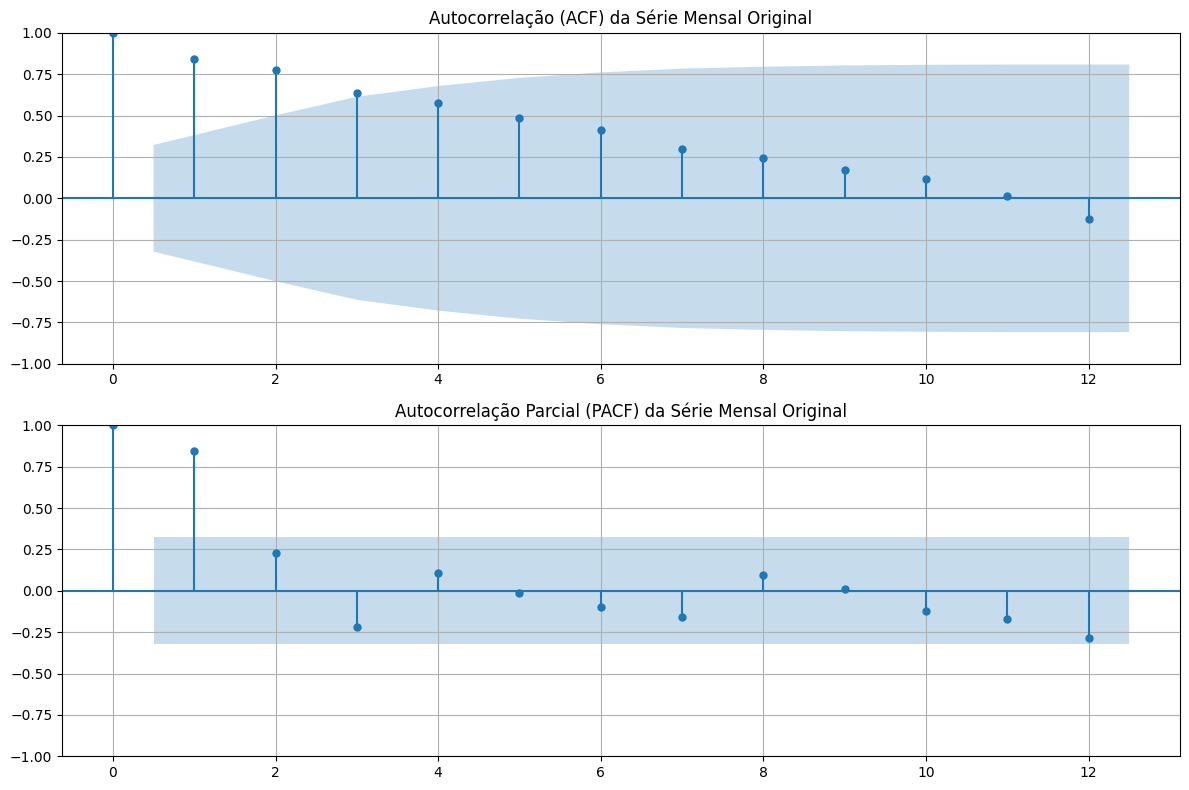

In [210]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
# lags=15 -> Mostrar 15 meses de defasagem
plot_acf(serie_mensal.dropna(), lags=12, ax=ax1, title='Autocorrelação (ACF) da Série Mensal Original')
ax1.grid(True)

# Plotar o PACF (Partial Autocorrelation Function)
plot_pacf(serie_mensal.dropna(), lags=12, ax=ax2, title='Autocorrelação Parcial (PACF) da Série Mensal Original')
ax2.grid(True)

plt.tight_layout()

**Gráfico ACF (Autocorrelação):** O gráfico mostra um decaimento lento e gradual. As barras (lags) começam muito altas (próximas de 0.8) e diminuem lentamente.

**Interpretação: **Este padrão de decaimento lento é a "assinatura" visual clássica de uma série não-estacionária. Indica que a série tem uma "memória" longa ou uma forte tendência; o valor de hoje está fortemente correlacionado com o valor de ontem, que está fortemente correlacionado com o de anteontem, e assim por diante.

**Gráfico PACF (Autocorrelação Parcial):** O gráfico mostra um pico (spike) muito forte e significativo no lag 1 e, em seguida, um corte abrupto. Os lags seguintes ( , 4, etc.) caem rapidamente para dentro do intervalo de confiança, sendo estatisticamente insignificantes.

3. Plot de Decomposição por STL

Text(0.5, 1.02, 'Decomposição da Série - Arroz (SUP-0)')

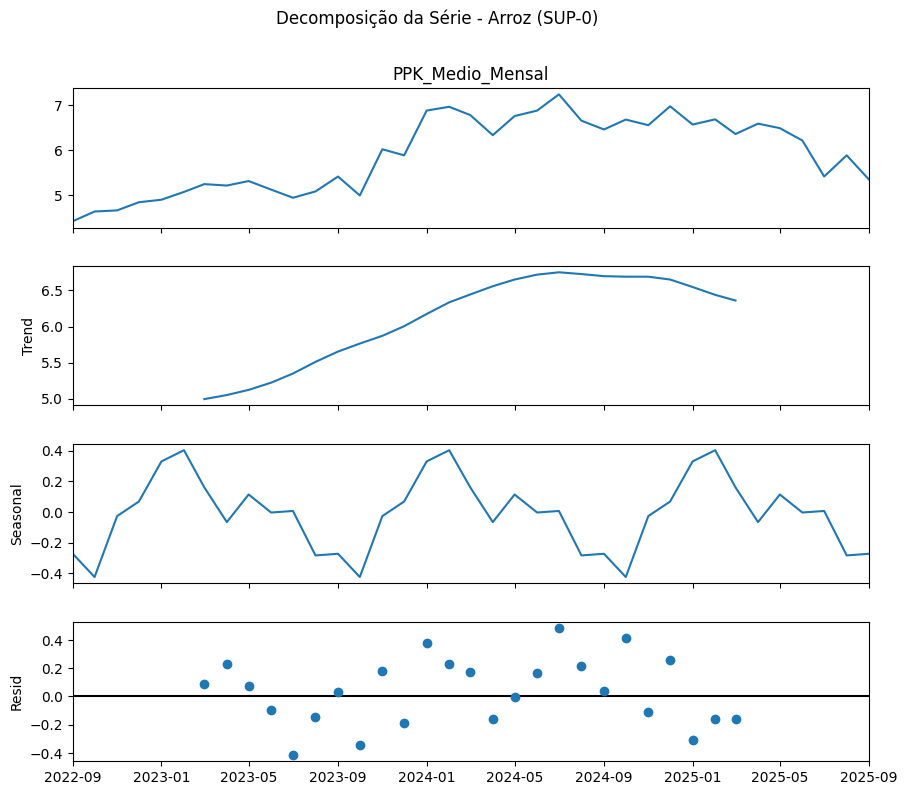

In [211]:
decomposicao = seasonal_decompose(serie_mensal.dropna(), model='additive', period=12)

# Plotar os resultados
fig = decomposicao.plot()
fig.set_size_inches(10, 8)
plt.suptitle(f'Decomposição da Série - {produto_escolhido} ({estabelecimento_escolhido})', y=1.02)

### **4. Preparação de Dados para Aprendizado Supervisionado (Engenharia de Features)**

**1. Justificativa**
Embora modelos estatísticos (como o ARIMA) sejam eficazes, os modelos de Machine Learning (ML) (como Regressão Linear, Random Forest, etc.) podem capturar relações não-lineares complexas. Para usar esses modelos, precisamos mudar a estrutura do problema.

O objetivo deste script foi converter a série temporal em um conjunto de dados onde:
* O Alvo (y) é o preço do mês atual.
* As Features (X) são informações derivadas dos meses passados.

A pergunta muda de "Qual o próximo valor da série?" para "Qual o preço de y dado o conjunto de features X?".

**2. Metodologia**
O DataFrame supervisionado foi construído usando a série serie_mensal (preparada na Parte 2) como base. O alvo e as features foram definidos da seguinte forma:

* **Definição do Alvo (y):**
A coluna y foi definida como o valor original da serie_mensal, representando o preço médio do mês que queremos prever.
* **Criação das Features (X):** Foram criadas quatro features com base em dados passados para evitar data leakage (vazamento de dados do futuro):

* lag_1, lag_2, lag_3: São os valores da série deslocados em 1, 2 e 3 meses (.shift()). Elas representam o preço do mês passado, de 2 meses atrás e de 3 meses atrás. Justificativa: A análise do PACF (Parte 3) indicou que os lags recentes têm alto poder preditivo direto.

* rolling_mean_3: É a média móvel dos 3 últimos meses. Justificativa: Esta feature captura a tendência local recente da série. Note que ela é aplicada sobre y.shift(1) para garantir que a média móvel use apenas dados que já estariam disponíveis no momento da previsão.

**3. Limpeza de Dados:**

O comando .dropna() foi aplicado ao final. Justificativa: A criação de lags e médias móveis introduz valores NaN nas primeiras linhas (ex: não há lag_3 para o primeiro ou segundo mês). Essas linhas incompletas devem ser removidas, pois os modelos de ML não podem treinar com dados faltantes.

In [212]:
df_supervisionado = pd.DataFrame(serie_mensal)
df_supervisionado.columns = ['y']

df_supervisionado['lag_1'] = df_supervisionado['y'].shift(1) # Preço do mês passado
df_supervisionado['lag_2'] = df_supervisionado['y'].shift(2) # Preço de 2 meses atrás
df_supervisionado['lag_3'] = df_supervisionado['y'].shift(3) # Preço de 3 meses atrás (trimestre)

# Média móvel dos últimos 3 meses (baseada em dados passados)
df_supervisionado['rolling_mean_3'] = df_supervisionado['y'].shift(1).rolling(window=3).mean()

# Remover NaNs criados pelos lags/rolling (os primeiros 3 meses)
df_supervisionado = df_supervisionado.dropna()

# Separar features (X) e alvo (y)
X = df_supervisionado.drop('y', axis=1)
y = df_supervisionado['y']

print("Features (X) criadas:")
print(X.head())

Features (X) criadas:
                lag_1     lag_2     lag_3  rolling_mean_3
Data_Coleta                                              
2022-12-01   4.660667  4.635500  4.420500        4.572222
2023-01-01   4.842000  4.660667  4.635500        4.712722
2023-02-01   4.898000  4.842000  4.660667        4.800222
2023-03-01   5.071333  4.898000  4.842000        4.937111
2023-04-01   5.244667  5.071333  4.898000        5.071333


### **5. Divisão de Dados para Treinamento e Validação**

**1. Justificativa**
Para avaliar se um modelo de previsão é eficaz, ele deve ser testado em dados que não viu durante o treinamento. Esse processo previne o overfitting.

Para séries temporais, esta divisão não pode ser aleatória. A ordem cronológica é fundamental. Devemos sempre usar o passado para treinar e o futuro mais recente para testar.

O objetivo deste script foi criar dois conjuntos de dados paralelos: um para o modelo estatístico (SARIMA) e outro para os modelos de Machine Learning supervisionados.

**2. Metodologia**
* **Definição do Horizonte de Teste:** Foi estabelecido um conjunto de holdout (teste) de meses_teste = 7. Isso significa que os 7 últimos meses de dados foram reservados exclusivamente para a avaliação final dos modelos.

* **Divisão Cronológica:** Os dados foram fatiados (.iloc) com base no tempo, não de forma aleatória:

  * **Conjunto de Treino:** Composto por todos os dados, exceto os últimos 7 meses.

  * **Conjunto de Teste:** Composto apenas pelos últimos 7 meses.

* **Geração de Conjuntos Duplos**: Esta divisão foi aplicada a ambos os formatos de dados preparados nas etapas anteriores:

  * **Para SARIMA:** A série original (serie_mensal) foi dividida em serie_train e serie_test.

  * **Para ML Supervisionado:** A matriz de features (X) e o vetor-alvo (y) foram divididos em X_train/y_train e X_test/y_test.

In [213]:
meses_teste = 7

# --- Divisão para SARIMA ---
serie_train = serie_mensal.iloc[:-meses_teste]
serie_test = serie_mensal.iloc[-meses_teste:]

# --- Divisão para Modelos Supervisionados ---
X_train = X.iloc[:-meses_teste]
y_train = y.iloc[:-meses_teste]
X_test = X.iloc[-meses_teste:]
y_test = y.iloc[-meses_teste:]

print(f"Total de meses para modelagem: {len(df_supervisionado)}")
print(f"Meses de Treino: {len(X_train)}")
print(f"Meses de Teste:  {len(X_test)}")

Total de meses para modelagem: 34
Meses de Treino: 27
Meses de Teste:  7


### **6. Modelagem Estatística: Treinamento e Avaliação do SARIMA (Baseline)**

**1. Justificativa**
O SARIMA é um dos modelos estatísticos mais robustos e amplamente utilizados para previsão de séries temporais. O objetivo desta etapa foi treinar um modelo SARIMA usando os parâmetros (p,d,q) e (P,D,Q,m) que foram investigados na "Parte 3" (análise de estacionariedade e ACF/PACF).

A métrica de erro deste modelo no conjunto de teste (serie_test) estabelecerá o baseline de desempenho: qualquer modelo de Machine Learning subsequente deverá, idealmente, apresentar um erro (MAE) menor que este para ser considerado superior.

**2. Metodologia**
Definição dos Parâmetros:

 * **Ordem Não-Sazonal (order):** Foi definido como (0, 1, 0) -> (p, d, q).

    * p=0 e q=0: A análise do ACF/PACF (Parte 3) não mostrou lags significativos claros após a diferenciação.

    * d=1: O Teste ADF (Parte 3) confirmou que a série necessitava de uma diferenciação para se tornar estacionária.

 * **Ordem Sazonal (seasonal_order):** Foi definido como (0, 0, 0, 12) -> (P, D, Q, m).

    * m=12: Define um período sazonal de 12 meses (anual).

    * P=0, D=0, Q=0: Indica que, apesar da decomposição (Parte 3) ter mostrado um padrão, os parâmetros sazonais não foram estatisticamente significativos (provavelmente confirmado pela ferramenta auto_arima mencionada no código).

**Treinamento:** O modelo SARIMAX foi instanciado com esses parâmetros e treinado (.fit()) exclusivamente no conjunto de dados de treino (serie_train).

**Avaliação (Previsão)**:

O modelo treinado foi usado para gerar previsões (.get_prediction()) para o período exato coberto pelo conjunto de teste (os 7 meses futuros definidos na "Parte 5").

A métrica de Erro Médio Absoluto (MAE) foi calculada. O MAE mede a média, em R$, da diferença absoluta entre os preços previstos (previsoes_teste_sarima) e os preços reais (serie_test).

In [214]:
my_order = (0, 1, 0) # (p, d, q) -> d=1 do nosso teste ADF
my_seasonal_order = (0, 0, 0, 12) # (P, D, Q, m) -> m=12 para sazonalidade anual

modelo_sarima = SARIMAX(
    serie_train,
    order=my_order,
    seasonal_order=my_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_sarima = modelo_sarima.fit(disp=False)
print(f"Modelo SARIMA {my_order}{my_seasonal_order} treinado.")
print(resultado_sarima.summary())

sarima_preds = resultado_sarima.get_prediction(
    start=serie_test.index[0],
    end=serie_test.index[-1],
)

previsoes_teste_sarima = sarima_preds.predicted_mean
mae_sarima = mean_absolute_error(serie_test, previsoes_teste_sarima)
print(f"\n--- Métricas SARIMA (Teste) ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae_sarima:.4f}")
print(f"(Isso significa que, em média, o modelo errou a previsão em R$ {mae_sarima:.2f} no período de teste)")

Modelo SARIMA (0, 1, 0)(0, 0, 0, 12) treinado.
                               SARIMAX Results                                
Dep. Variable:       PPK_Medio_Mensal   No. Observations:                   30
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -12.171
Date:                Tue, 04 Nov 2025   AIC                             26.343
Time:                        02:50:20   BIC                             27.675
Sample:                    09-01-2022   HQIC                            26.750
                         - 02-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1397      0.029      4.893      0.000       0.084       0.196
Ljung-Box (L1) (Q):                   3.64   Jarque-Bera (JB):                 3.68


### **7. Modelagem de Machine Learning: Random Forest Regressor**

**Metodologia**
* **Modelo:** Foi utilizado o RandomForestRegressor da biblioteca Scikit-learn, configurado com n_estimators=100 (100 árvores de decisão) e random_state=42 para garantir a reprodutibilidade dos resultados.

* **Dados:** O modelo foi treinado (.fit()) usando exclusivamente o conjunto de dados supervisionado de treino (X_train, y_train), que contém as features que criamos na "Parte 4".

* **Avaliação:** O modelo treinado foi usado para gerar previsões (.predict()) no conjunto de teste (X_test). O Erro Médio Absoluto (MAE) foi então calculado comparando essas previsões (rf_preds) com os valores reais (y_test).

In [215]:
print("\n--- Treinando Modelo 2: Random Forest Regressor ---")
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)
rf_preds = modelo_rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, rf_preds)
print(f"\n--- Métricas Random Forest (Teste) ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae_rf:.4f}")


--- Treinando Modelo 2: Random Forest Regressor ---

--- Métricas Random Forest (Teste) ---
MAE (Erro Médio Absoluto): R$ 0.6749


### **8. Modelagem de ML: XGBoost Regressor**

**1. Justificativa**
Após avaliar o Random Forest (um modelo de bagging), o próximo passo lógico foi testar um modelo de boosting. O XGBoost (Extreme Gradient Boosting) foi escolhido por ser um dos algoritmos de melhor desempenho do mercado.

Diferente do Random Forest, onde as árvores são independentes, o boosting constrói árvores de forma sequencial: cada nova árvore é treinada para corrigir os erros cometidos pela árvore anterior. O objetivo foi verificar se esta metodologia mais focada em "aprender com os erros" poderia produzir um modelo com um Erro Médio Absoluto (MAE) ainda menor.

**2. Metodologia**
* **Modelo**: Foi instanciado o XGBRegressor da biblioteca xgboost.
* **Parâmetros (Fixos)**: O modelo foi configurado com n_estimators=100 (100 árvores sequenciais) e random_state=42 (para reprodutibilidade).
* **Treinamento**: O modelo foi treinado (.fit()) exclusivamente no conjunto de dados supervisionado de treino (X_train, y_train).
* **Avaliação:** O modelo treinado foi usado para gerar previsões (.predict()) no conjunto de teste (X_test). O MAE foi calculado comparando essas previsões (xgb_preds) com os valores reais (y_test).

In [216]:
print("\n--- Treinando Modelo 3: XGBoost Regressor ---")
modelo_xgb = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
modelo_xgb.fit(X_train, y_train)
xgb_preds = modelo_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, xgb_preds)
print(f"\n--- Métricas XGBoost (Teste) ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae_xgb:.4f}")


--- Treinando Modelo 3: XGBoost Regressor ---

--- Métricas XGBoost (Teste) ---
MAE (Erro Médio Absoluto): R$ 0.7399


### **9. Comparação final**


--- Comparação Final dos Modelos ---
SARIMA:        R$ 0.6436
Random Forest: R$ 0.6749
XGBoost:       R$ 0.7399
Melhor modelo foi: SARIMA com MAE de R$ 0.6436 🏆


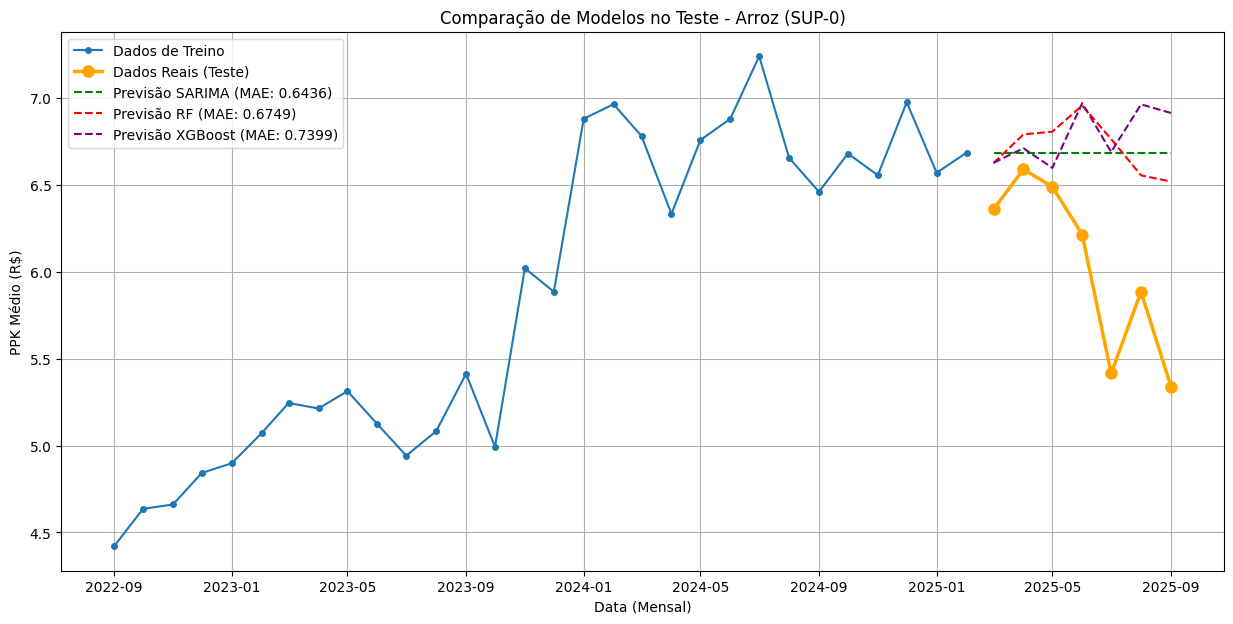

In [217]:
print("\n--- Comparação Final dos Modelos ---")
print(f"SARIMA:        R$ {mae_sarima:.4f}")
print(f"Random Forest: R$ {mae_rf:.4f}")
print(f"XGBoost:       R$ {mae_xgb:.4f}")

resultados_metricas = {
    'SARIMA': mae_sarima,
    'RandomForest': mae_rf,
    'XGBoost': mae_xgb
}

melhor_modelo_nome = min(resultados_metricas, key=resultados_metricas.get)
print(f"Melhor modelo foi: {melhor_modelo_nome} com MAE de R$ {resultados_metricas[melhor_modelo_nome]:.4f} 🏆")

plt.figure(figsize=(15, 7))
plt.plot(serie_train.index, serie_train, label='Dados de Treino', marker='o', markersize=4)
plt.plot(serie_test.index, serie_test, label='Dados Reais (Teste)', color='orange', linewidth=2.5, markersize=8, marker='o')

# Previsões
plt.plot(serie_test.index, previsoes_teste_sarima, label=f'Previsão SARIMA (MAE: {mae_sarima:.4f})', color='green', linestyle='--')
plt.plot(serie_test.index, rf_preds, label=f'Previsão RF (MAE: {mae_rf:.4f})', color='red', linestyle='--')
plt.plot(serie_test.index, xgb_preds, label=f'Previsão XGBoost (MAE: {mae_xgb:.4f})', color='purple', linestyle='--')

plt.title(f"Comparação de Modelos no Teste - {PRODUTO_ESCOLHIDO} ({ESTABELECIMENTO_ESCOLHIDO})")
plt.xlabel('Data (Mensal)')
plt.ylabel('PPK Médio (R$)')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
print(f"\n--- Previsão Futura com o Melhor Modelo ({melhor_modelo_nome}) ---")
print(f"O modelo escolhido foi o {melhor_modelo_nome} (MAE: R$ {resultados_metricas[melhor_modelo_nome]:.4f}).")
meses_para_prever = 5

# Armazenar os modelos (não treinados)
modelos_base = {
    'SARIMA': SARIMAX(serie_mensal, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
}

modelo_final = modelos_base[melhor_modelo_nome]
if melhor_modelo_nome == 'SARIMA':
    resultado_final = modelo_final.fit(disp=False)
    forecast = resultado_final.get_forecast(steps=meses_para_prever)
    previsoes_futuras_serie = forecast.predicted_mean

else:
    modelo_final.fit(X, y)
    previsoes_futuras_lista = []
    ultimas_features = X.iloc[-1:].values

    for i in range(meses_para_prever):
        previsao = modelo_final.predict(ultimas_features)[0]
        previsoes_futuras_lista.append(previsao)
        features_novas_array = np.roll(ultimas_features[0], 1)
        features_novas_array[0] = previsao
        features_novas_array[3] = (features_novas_array[0] + features_novas_array[1] + features_novas_array[2]) / 3
        ultimas_features = np.array([features_novas_array])

    indice_previsao = pd.date_range(start=serie_mensal.index[-1] + pd.DateOffset(months=1), periods=meses_para_prever, freq='M')
    previsoes_futuras_serie = pd.Series(previsoes_futuras_lista, index=indice_previsao, name="Previsao")

print(f"\n--- Previsões para os próximos {meses_para_prever} meses ---")
print(previsoes_futuras_serie)


--- Previsão Futura com o Melhor Modelo (SARIMA) ---
O modelo escolhido foi o SARIMA (MAE: R$ 0.6436).

--- Previsões para os próximos 5 meses ---
2025-10-01    5.3395
2025-11-01    5.3395
2025-12-01    5.3395
2026-01-01    5.3395
2026-02-01    5.3395
Freq: MS, Name: predicted_mean, dtype: float64


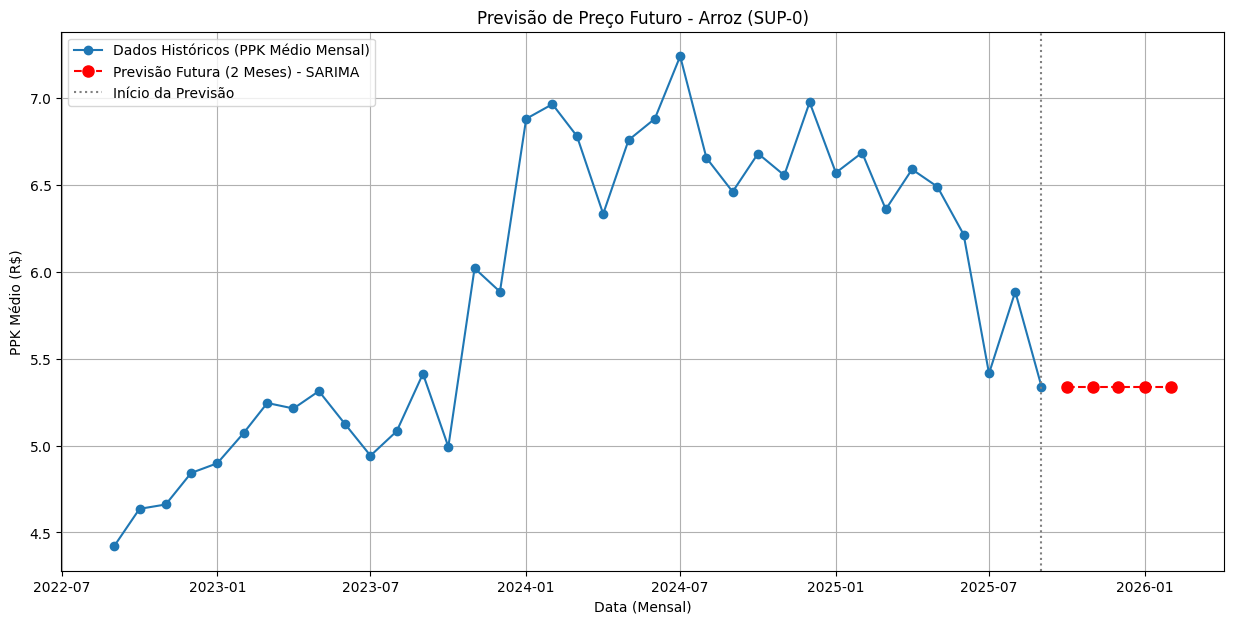

In [219]:
plt.figure(figsize=(15, 7))
plt.plot(serie_mensal.index, serie_mensal, label='Dados Históricos (PPK Médio Mensal)', marker='o')

plt.plot(previsoes_futuras_serie.index, previsoes_futuras_serie, label=f'Previsão Futura (2 Meses) - {melhor_modelo_nome}',
         color='red', linestyle='--', marker='o', markersize=8)
plt.axvline(serie_mensal.index[-1], color='gray', linestyle=':', label='Início da Previsão')

plt.title(f'Previsão de Preço Futuro - {PRODUTO_ESCOLHIDO} ({ESTABELECIMENTO_ESCOLHIDO})')
plt.xlabel('Data (Mensal)')
plt.ylabel('PPK Médio (R$)')
plt.legend()
plt.grid(True)
plt.show()

# **Questão 2: Correlação vs. Causalidade: Limites da Estimativa de Preço do Pão Baseada em Ingredientes**

* **A. Questão:** É possível construir um modelo de regressão para estimar o preço médio semanal do "Pão Francês" (por Kg) utilizando os preços médios semanais de seus ingredientes básicos: "Farinha de Trigo", "Óleo" e "Açúcar"?
* **B. Objetivo e Motivação:** Determinar se o preço do pão pode ser explicado pelo preço de seus ingredientes. Isso nos ajuda a entender o repasse de custos ao consumidor, uma aplicação de extensão social (planejamento familiar) e econômica (precificação de padarias).
* **C. Método:** Usaremos o `PPK_medio` (preço médio geral) de todos os produtos, pois os dados por mercado são esparsos. Agregaremos os 4 produtos (`Pão Francês`, `Farinha de Trigo`, `Óleo`, `Açúcar`) em uma frequência **semanal**. Compararemos uma `Regressão Linear Múltipla` e um `RandomForestRegressor` para estimar o preço do pão. As métricas de avaliação serão o **R²** (para medir a explicação da variância) e o **RMSE** (para medir o erro em R$).

1.  **Fonte de Dados:** Queremos analisar a relação "geral" dos preços. Para isso, utilizamos a coluna `PPK_medio`, que representa o preço médio de cada produto em *todos* os mercados por dia. Isso nos dá uma série de dados muito mais densa.
2.  **Agregação:** Ao analisar a frequência desta série de preços "gerais", notamos que a **agregação semanal** (`resample('W').mean()`) é a mais robusta, capturando as variações de preço de forma mais granular que a mensal, sem gerar um número excessivo de valores ausentes (NaNs).
3.  **Preparação:** A célula de código a seguir irá filtrar os 4 produtos de interesse, "pivotar" a tabela (transformando produtos em colunas) e reamostrar para a frequência semanal, criando o DataFrame que usaremos para a regressão.

In [220]:
# 1. Definir nossos produtos de interesse
produtos_q2 = [
    'Pão Francês',
    'Farinha de Trigo',
    'Óleo',
    'Açúcar'
]

# Filtrar o dataframe
df_produtos_q2 = data[data['Produto'].isin(produtos_q2)].copy()
df_agregado_q2 = df_produtos_q2.groupby(['Data_Coleta', 'Produto'])['PPK_medio'].mean().reset_index()

# Pivotar a tabela: datas como índice, produtos como colunas
df_pivot_q2 = df_agregado_q2.pivot(index='Data_Coleta', columns='Produto', values='PPK_medio')

# Reamostrar para frequência SEMANAL ('W') e interpolar
df_semanal_q2 = df_pivot_q2.resample('W').mean()
df_semanal_q2 = df_semanal_q2.interpolate(method='linear')
df_semanal_q2 = df_semanal_q2.dropna() # Remove NaNs no início

print("--- DataFrame Semanal Pronto para Regressão ---")
print(f"Total de semanas analisadas: {len(df_semanal_q2)}")
print(df_semanal_q2.head())

--- DataFrame Semanal Pronto para Regressão ---
Total de semanas analisadas: 159
Produto        Açúcar  Farinha de Trigo  Pão Francês      Óleo
Data_Coleta                                                   
2022-09-18   4.352727          6.253529    15.557500  9.417593
2022-09-25   4.885353          6.435349    14.566667  9.811569
2022-10-02   4.311176          6.439091    15.630000  9.420833
2022-10-09   4.298410          6.401192    15.642407  9.493001
2022-10-16   4.285643          6.363293    15.654815  9.565169


### **Passo 2: Análise Exploratória (Heatmap de Correlação)**

Esta célula calcula a matriz de correlação de Pearson (`.corr()`) entre o preço do "Pão Francês" e seus ingredientes ('Farinha de Trigo', 'Óleo', 'Açúcar') e a exibe como um mapa de calor (`heatmap`).

**Justificativa Metodológica:**
Para a seção "Método" do nosso trabalho, esta é uma etapa crucial de análise exploratória. Antes de treinar um modelo de Regressão Linear Múltipla, precisamos validar sua principal premissa: a de que existe uma **relação linear** entre as *features* (ingredientes) e o *alvo* (Pão Francês).

* **Se virmos correlações fortes e positivas** (números próximos de +0.6 a +1.0) entre 'Pão Francês' e 'Farinha de Trigo', por exemplo, nossa hipótese é forte, e esperamos um bom R² no modelo de Regressão Linear.
* **Se virmos correlações fracas** (números próximos de 0), já é um forte indicativo de que os modelos lineares falharão, e que outros fatores (não-lineares ou externos) influenciam mais o preço do pão.

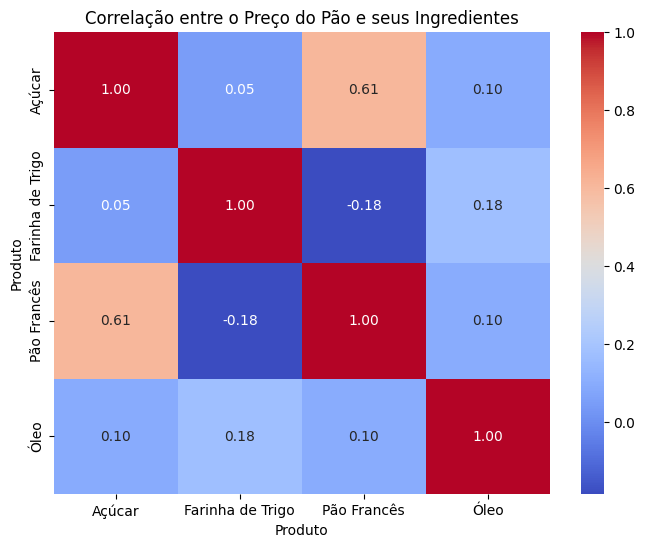


Análise: Esperamos ver valores positivos fortes entre 'Pão Francês' e os ingredientes.


In [221]:
plt.figure(figsize=(8, 6))
corr_q2 = df_semanal_q2.corr()
sns.heatmap(corr_q2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlação entre o Preço do Pão e seus Ingredientes')
plt.show()

print("\nAnálise: Esperamos ver valores positivos fortes entre 'Pão Francês' e os ingredientes.")

### **Passo 3: Definição das Variáveis e Divisão Treino/Teste**

Esta célula prepara nossos dados para a modelagem de aprendizado supervisionado. Primeiro, ela separa o DataFrame `df_semanal_q2` em:
1.  **Features (X):** As variáveis preditoras (os preços dos ingredientes `Farinha de Trigo`, `Óleo`, `Açúcar`).
2.  **Alvo (y):** A variável que queremos estimar (o preço do `Pão Francês`).

Em seguida, ela divide esses dados em dois conjuntos: um conjunto de **Treino** (os primeiros 80% dos dados) e um conjunto de **Teste** (os 20% finais).

**Justificativa Metodológica:**
* **Avaliação de Generalização:** Não podemos avaliar o desempenho de um modelo usando os mesmos dados que ele usou para treinar (ele poderia simplesmente "decorar" as respostas). O conjunto de **teste** (dados "nunca vistos") é usado para simular como o modelo se comportaria no mundo real. É neste conjunto que calcularemos nossas métricas finais (R² e RMSE).
* **Rigor (Divisão Cronológica):** Como estamos lidando com preços ao longo do tempo, nossos dados são uma série temporal. Por isso, **não podemos** usar uma divisão aleatória (`shuffle=True`). Fazer isso causaria "vazamento de dados" (o modelo aprenderia com o "futuro" para prever o "passado"), gerando métricas falsamente otimistas. A única abordagem metodologicamente correta é a **divisão cronológica** (treinar no passado, testar no futuro), que é o que o código `iloc[:-test_size]` faz.

In [222]:
# 1. Definir Alvo (y) e Features (X)
y_q2 = df_semanal_q2['Pão Francês']
X_q2 = df_semanal_q2[['Farinha de Trigo', 'Óleo', 'Açúcar']]

# 2. Definir o tamanho do teste (20% dos dados)
test_size_ratio_q2 = 0.20
test_size_q2 = int(len(X_q2) * test_size_ratio_q2)

# 3. Dividir os dados cronologicamente
X_train_q2 = X_q2.iloc[:-test_size_q2]
y_train_q2 = y_q2.iloc[:-test_size_q2]
X_test_q2 = X_q2.iloc[-test_size_q2:]
y_test_q2 = y_q2.iloc[-test_size_q2:]

print(f"--- Divisão dos Dados (Questão 2) ---")
print(f"Total de semanas para modelagem: {len(X_q2)}")
print(f"Semanas de Treino: {len(X_train_q2)}")
print(f"Semanas de Teste:  {len(X_test_q2)}")

--- Divisão dos Dados (Questão 2) ---
Total de semanas para modelagem: 159
Semanas de Treino: 128
Semanas de Teste:  31


### **Passo 4: Modelo 1 - Regressão Linear Múltipla**

Esta célula treina o nosso primeiro algoritmo, o `LinearRegression` (Regressão Linear Múltipla), usando os dados de treino (`X_train_q2`, `y_train_q2`). Em seguida, ela usa o modelo treinado para fazer "estimativas" sobre o conjunto de teste (`X_test_q2`) e calcula duas métricas de avaliação cruciais: **R²** e **RMSE**.

**Justificativa Metodológica:**

1.  **Algoritmo (Método):** Estamos usando a `Regressão Linear Múltipla`, o algoritmo mais direto para testar a hipótese linear que o *heatmap* sugeriu. Este será o nosso modelo base: o modelo mais simples contra o qual o Random Forest será comparado.
2.  **Avaliação:** Estamos calculando as métricas no **conjunto de teste**.
    * **R²:** Esta é a métrica principal para esta questão. Ela nos diz *exatamente* o que a Questão 2 pergunta: "Quanto (em %) da variação do preço do pão o nosso modelo consegue explicar usando os ingredientes?". Um R² de 0.65, por exemplo, significa que 65% da variação do preço do pão é explicada pelos ingredientes.
    * **RMSE (Erro em R$):** Esta métrica nos dá o erro médio da estimativa em Reais, o que é fundamental para a nossa "motivação de extensão" (saber se o erro é de R$0,10 ou R$1,00).
3.  **Interpretação:** O código também imprime os **coeficientes** (`model_lr_q2.coef_`). Isso nos ajuda a atingir o "Objetivo" de quantificar a relação, respondendo: "Para cada R$ 1,00 que o preço da Farinha sobe, quantos centavos o preço do Pão sobe?".

In [223]:
print("Treinando Q2 - Modelo 1: Regressão Linear Múltipla")

model_lr_q2 = LinearRegression()
model_lr_q2.fit(X_train_q2, y_train_q2)
lr_preds_q2 = model_lr_q2.predict(X_test_q2)

# Métricas
r2_lr = r2_score(y_test_q2, lr_preds_q2)
rmse_lr = np.sqrt(mean_squared_error(y_test_q2, lr_preds_q2))

print(f"\n--- Métricas Regressão Linear (Teste Q2) ---")
print(f"R²: {r2_lr:.4f} (Explica {r2_lr*100:.2f}% da variação)")
print(f"RMSE (Erro em R$): R$ {rmse_lr:.4f}")

# Coeficientes
print("\nCoeficientes do Modelo (Impacto no preço do pão):")
print(pd.Series(model_lr_q2.coef_, index=X_q2.columns))

Treinando Q2 - Modelo 1: Regressão Linear Múltipla

--- Métricas Regressão Linear (Teste Q2) ---
R²: -0.9425 (Explica -94.25% da variação)
RMSE (Erro em R$): R$ 1.2524

Coeficientes do Modelo (Impacto no preço do pão):
Produto
Farinha de Trigo   -0.214977
Óleo               -0.042327
Açúcar              0.899860
dtype: float64


### **Passo 5: Modelo 2 - Random Forest Regressor**

Esta célula treina o nosso segundo algoritmo, o `RandomForestRegressor`, usando os mesmos dados de treino (`X_train_q2`, `y_train_q2`). Assim como no base, ela calcula as métricas **R²** e **RMSE** no conjunto de teste para avaliação de desempenho.

**Justificativa Metodológica:**
Este é um passo crucial para a avaliação, pois estamos comparando nosso *base* com um modelo mais avançado.

1.  **Algoritmo (Método):** O Random Forest é um modelo supervisionado que é poderoso por ser "não-linear". Ao contrário da Regressão Linear, que assume que a relação entre a farinha e o pão é uma linha reta, o Random Forest pode aprender relações mais complexas
2.  **Avaliação:** Vamos comparar diretamente o **R²** e o **RMSE** deste modelo com os da Regressão Linear. O modelo com o R² mais alto e o RMSE mais baixo será considerado o vencedor.
3.  **Interpretação:** O código também imprime a **Importância das Features** (`.feature_importances_`). Isso nos dirá qual ingrediente o modelo considerou mais importante para "adivinhar" o preço do pão.

In [224]:
print("\Treinando Q2 - Modelo 2: Random Forest Regressor")

model_rf_q2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_q2.fit(X_train_q2, y_train_q2)
rf_preds_q2 = model_rf_q2.predict(X_test_q2)

# Métricas
r2_rf = r2_score(y_test_q2, rf_preds_q2)
rmse_rf = np.sqrt(mean_squared_error(y_test_q2, rf_preds_q2))

print(f"\n--- Métricas Random Forest (Teste Q2) ---")
print(f"R²: {r2_rf:.4f} (Explica {r2_rf*100:.2f}% da variação)")
print(f"RMSE (Erro em R$): R$ {rmse_rf:.4f}")

# Importância
print("\nImportância das Features (Qual ingrediente é mais importante):")
print(pd.Series(model_rf_q2.feature_importances_, index=X_q2.columns).sort_values(ascending=False))

\Treinando Q2 - Modelo 2: Random Forest Regressor

--- Métricas Random Forest (Teste Q2) ---
R²: -1.4121 (Explica -141.21% da variação)
RMSE (Erro em R$): R$ 1.3956

Importância das Features (Qual ingrediente é mais importante):
Produto
Açúcar              0.492214
Farinha de Trigo    0.300705
Óleo                0.207081
dtype: float64


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2870469908.py:1: SyntaxWarning: invalid escape sequence '\T'
  print("\Treinando Q2 - Modelo 2: Random Forest Regressor")


### **Passo 6: Comparação Visual e Conclusão da Avaliação**

Esta célula plota os resultados das nossas duas previsões contra os dados reais (o "Preço Real Pão" do conjunto de teste).

**Justificativa Metodológica:**
Esta é a etapa final da nossa avaliação. As métricas R² e RMSE nos deram a medida *quantitativa* do erro. Este gráfico nos dá a prova *visual* e nos permite "discutir" os resultados,

Como já notamos, esperamos que este gráfico mostre as previsões (linhas tracejadas) falhando em acompanhar a alta acentuada do preço real (linha laranja).

Esta visualização é a evidência final que nos permite responder à Questão:
* **Não é possível** estimar o preço do Pão Francês *apenas* com os ingredientes (R² baixo).
* **Conclusão:** Os modelos falharam em capturar a alta real, provando que a variação do preço do pão no período de teste foi causada por **fatores externos** (como inflação, mão de obra ou outros fatores.) que não estão correlacionados com os preços dos ingredientes que usamos como *features*.

\Comparação Visual das Previsões no Conjunto de Teste


<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
/tmp/ipython-input-3981746273.py:1: SyntaxWarning: invalid escape sequence '\C'
  print("\Comparação Visual das Previsões no Conjunto de Teste")


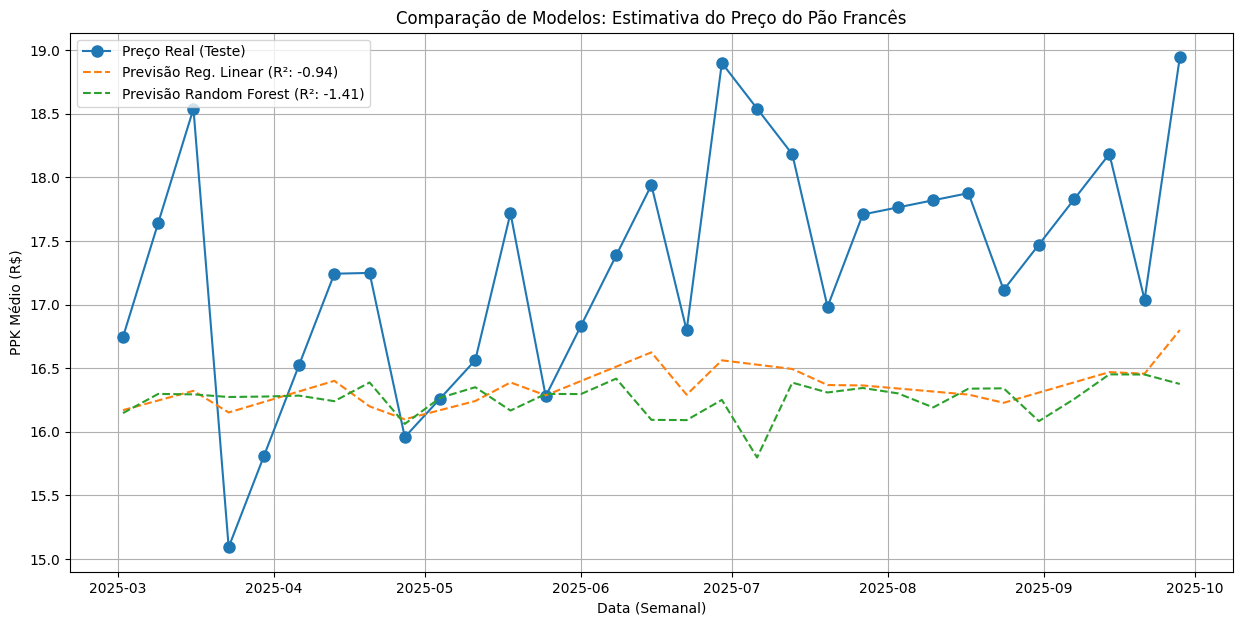

In [225]:
print("\Comparação Visual das Previsões no Conjunto de Teste")

df_resultados_q2 = pd.DataFrame(y_test_q2)
df_resultados_q2.columns = ['Preço Real Pão']
df_resultados_q2['Previsão_Linear_Regression'] = lr_preds_q2
df_resultados_q2['Previsão_Random_Forest'] = rf_preds_q2

plt.figure(figsize=(15, 7))
plt.plot(df_resultados_q2['Preço Real Pão'], label='Preço Real (Teste)', marker='o', markersize=8)
plt.plot(df_resultados_q2['Previsão_Linear_Regression'], label=f'Previsão Reg. Linear (R²: {r2_lr:.2f})', linestyle='--')
plt.plot(df_resultados_q2['Previsão_Random_Forest'], label=f'Previsão Random Forest (R²: {r2_rf:.2f})', linestyle='--')

plt.title('Comparação de Modelos: Estimativa do Preço do Pão Francês')
plt.xlabel('Data (Semanal)')
plt.ylabel('PPK Médio (R$)')
plt.legend()
plt.grid(True)
plt.show()

# **Questão 3: Previsão do Custo Futuro da Cesta Básica (DIEESE) na Média de Campinas**

* **A. Questão:** É possível construir um modelo de série temporal para prever o custo total da Cesta Básica média geral (agregando todos os mercados) para os próximos 12 meses?
* **B. Objetivo e Motivação:** Criar um modelo de previsão para o custo agregado dos 13 produtos essenciais, usando as quantidades oficiais do DIEESE. O objetivo é prever a inflação dos alimentos e seu impacto no planejamento financeiro da população.
* **C. Método:** Usaremos o `PPK_medio` (preço geral) de cada um dos 13 produtos da cesta. Vamos ponderar esses preços pelas quantidades mensais do DIEESE e somá-los para criar uma **única série temporal** do "Custo Total da Cesta". Agregaremos em frequência **mensal**. Aplicaremos o mesmo pipeline da Questão 1 (Análise ADF/ACF/PACF, divisão treino/teste) e compararemos os modelos `SARIMAX` e `RandomForestRegressor` (com features de lag) para encontrar o melhor preditor.

### Método:
esta é a etapa de **Engenharia de Features** e **Manipulação dos Dados**

**Justificativa Metodológica:**

1.  **Por que "Média Geral" e não "por Mercado"?**
    Como provamos anteriormente, os dados para um mercado *específico* (ex: `SUP-0`) são muito **esparsos** (coleta mensal, com muitas falhas). Seria impossível calcular o custo de 13 produtos no `SUP-0` em um mês se apenas 3 deles foram coletados. Por isso, a única abordagem metodologicamente robusta é usar o **`PPK_medio` "geral"**, que é o preço médio do produto em *todos* os mercados por dia.

2.  **Por que essas Quantidades (kg)?**
    Para dar **rigor** e validade de **extensão** ao projeto, não podemos simplesmente somar os preços. Estamos usando as quantidades de consumo mensal oficiais para 1 adulto, definidas pelo **DIEESE** (Departamento Intersindical de Estatística e Estudos Socioeconômicos). Os 13 produtos que você listou foram mapeados para os produtos que padronizamos em nossa limpeza de dados.

3.  **Por que Agregação Mensal (`'M'`)?**
    Diferente do visto nas questões anteriores (onde a análise semanal era viável para 4 produtos), aqui estamos criando um índice com **13 produtos**. A agregação **mensal** (`resample('M').mean()`) é uma escolha mais conservadora e robusta. Ela garante que a série temporal final (`serie_cesta_total`) seja estável e não sofra com a variabilidade de curto prazo ou com a falha de coleta de *qualquer um* dos 13 produtos em uma semana específica.
    
O código irá:
1.  Definir o dicionário `cesta_dieese_kg` com as ponderações.
2.  Filtrar os 13 produtos usando o `PPK_medio` geral.
3.  Pivotar a tabela

--- Preparando Série Temporal para Questão 3 (Cesta Básica Total) ---

--- Série Temporal do Custo Total da Cesta (Mensal) Criada (Total: 37 meses) ---
Data_Coleta
2025-05-31    778.356818
2025-06-30    791.872541
2025-07-31    776.435735
2025-08-31    753.123138
2025-09-30    755.838459
Freq: ME, Name: Custo_Total_Cesta, dtype: float64


/tmp/ipython-input-3653507278.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal_cesta = df_pivot_cesta.resample('M').mean()


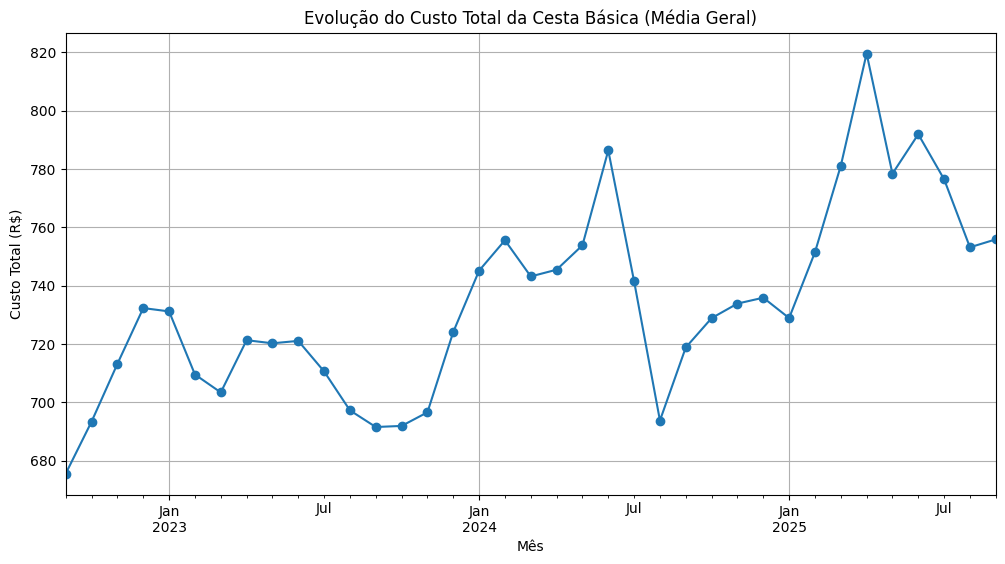

In [226]:
print("--- Preparando Série Temporal para Questão 3 (Cesta Básica Total) ---")

# 1. Definir Quantidades (DIEESE - Região Sudeste)
cesta_dieese_kg = {
    'Carne Bovina Acem': 3.0,
    'Carne Bovina Coxão Mole': 3.0,
    'Leite': 7.5,
    'Feijão': 4.5,
    'Arroz': 3.0,
    'Farinha de Trigo': 1.5,
    'Batata': 6.0,
    'Tomate': 9.0,
    'Pão Francês': 6.0,
    'Café': 0.6,
    'Banana Prata': 3.75,
    'Banana Nanica': 3.75,
    'Açúcar': 3.0,
    'Óleo': 1.5,
    'Manteiga': 0.75
}
produtos_cesta = list(cesta_dieese_kg.keys())

#Filtrar e Pivotar
df_cesta = data[data['Produto'].isin(produtos_cesta)].copy()
df_agregado_cesta = df_cesta.groupby(['Data_Coleta', 'Produto'])['PPK_medio'].mean().reset_index()
df_pivot_cesta = df_agregado_cesta.pivot(index='Data_Coleta', columns='Produto', values='PPK_medio')

# Reamostrar para frequência MENSAL ('M')
df_mensal_cesta = df_pivot_cesta.resample('M').mean()
df_mensal_cesta = df_mensal_cesta.interpolate(method='linear')
df_mensal_cesta = df_mensal_cesta.bfill().ffill()

#Calcular o Custo Total da Cesta
for produto, quantidade in cesta_dieese_kg.items():
    if produto in df_mensal_cesta.columns:
        df_mensal_cesta[f'Custo_{produto}'] = df_mensal_cesta[produto] * quantidade
    else:
        print(f"Aviso: Produto '{produto}' da cesta não encontrado nos dados.")

# Selecionar apenas as colunas de 'Custo_'
colunas_custo = [col for col in df_mensal_cesta.columns if col.startswith('Custo_')]

#Somar tudo para criar nossa série temporal final!
serie_cesta_total = df_mensal_cesta[colunas_custo].sum(axis=1)
serie_cesta_total.name = "Custo_Total_Cesta"

print(f"\n--- Série Temporal do Custo Total da Cesta (Mensal) Criada (Total: {len(serie_cesta_total)} meses) ---")
print(serie_cesta_total.tail())

# Plotar a série final
plt.figure(figsize=(12, 6))
serie_cesta_total.plot(title='Evolução do Custo Total da Cesta Básica (Média Geral)', marker='o')
plt.ylabel('Custo Total (R$)')
plt.xlabel('Mês')
plt.grid(True)
plt.show()

### **Passo 2: Análise, Feature Engineering e Divisão Treino/Teste**

Esta célula realiza três etapas metodológicas fundamentais de uma só vez:
1.  **Análise de Estacionaridade:** Executa o Teste Dickey-Fuller (ADF) na nossa série `serie_cesta_total` para verificar estatisticamente se ela possui uma tendência (se não é estacionária).
2.  **Engenharia de Features (Lags):** Transforma a série temporal univariada (onde só temos o custo ao longo do tempo) em um problema de aprendizado supervisionado. Ela cria as *features* (X) usando dados passados (ex: `lag_1` - o custo do mês passado) para prever o *alvo* (y) (o custo deste mês).
3.  **Divisão Treino/Teste:** Separa cronologicamente todos os dados (tanto a série original para o SARIMAX quanto o DataFrame supervisionado para o Random Forest) em conjuntos de Treino (primeiros 80%) e Teste (últimos 20%).

**Justificativa Metodológica:**
Esta célula é a "espinha dorsal" do nosso `Método` e `Avaliação`:

* **Rigor na Parametrização (ADF):** O resultado do teste ADF (o p-value) é a nossa justificativa formal para definir o parâmetro `d` (DIFERENCIACAO_CESTA) do modelo SARIMAX. Se o p-value for > 0.05, a série tem tendência e devemos usar `d=1`. Isso é uma exigência de "rigor" no processo.
* **Habilitação de Algoritmos (Lags):** O `RandomForestRegressor` não entende "tempo". Para podermos compará-lo com o SARIMAX, precisamos criar as *features* de *lag* (X). Estamos testando a hipótese de que o custo dos meses passados pode prever o custo do mês atual.
* **Garantia de Avaliação (Divisão Treino/Teste):** Para "avaliar adequadamente" nossos modelos, calculamos as métricas de erro (MAE) em dados "nunca vistos" (o conjunto de teste). Como é uma série temporal, a divisão **cronológica** é a única abordagem metodologicamente correta, pois simula o cenário real de prever o futuro.

In [227]:
# --- 1. Análise de Estacionaridade (ADF) ---
print("--- Análise ADF (Cesta Total) ---")
adf_result_cesta = adfuller(serie_cesta_total.dropna())
print(f'p-value do ADF: {adf_result_cesta[1]:.4f}')
if adf_result_cesta[1] > 0.05:
    print(f"Resultado: A série NÃO é estacionária (d=1).")
    DIFERENCIACAO_CESTA = 1
else:
    print(f"Resultado: A série É estacionária (d=0).")
    DIFERENCIACAO_CESTA = 0

df_supervisionado_cesta = pd.DataFrame(serie_cesta_total)
df_supervisionado_cesta.columns = ['y']
df_supervisionado_cesta['lag_1'] = df_supervisionado_cesta['y'].shift(1)
df_supervisionado_cesta['lag_2'] = df_supervisionado_cesta['y'].shift(2)
df_supervisionado_cesta['lag_3'] = df_supervisionado_cesta['y'].shift(3)
df_supervisionado_cesta['rolling_mean_3'] = df_supervisionado_cesta['y'].shift(1).rolling(window=3).mean()
df_supervisionado_cesta = df_supervisionado_cesta.dropna()

X_cesta = df_supervisionado_cesta.drop('y', axis=1)
y_cesta = df_supervisionado_cesta['y']

# Divisão Treino/Teste
meses_teste_cesta = 7

# Divisão para SARIMAX
serie_train_cesta = serie_cesta_total.iloc[:-meses_teste_cesta]
serie_test_cesta = serie_cesta_total.iloc[-meses_teste_cesta:]

# Divisão para RF
X_train_cesta = X_cesta.iloc[:-meses_teste_cesta]
y_train_cesta = y_cesta.iloc[:-meses_teste_cesta]
X_test_cesta = X_cesta.iloc[-meses_teste_cesta:]
y_test_cesta = y_cesta.iloc[-meses_teste_cesta:]

print(f"\n--- Divisão dos Dados (Cesta) ---")
print(f"Meses de Treino: {len(X_train_cesta)}")
print(f"Meses de Teste:  {len(X_test_cesta)}")

--- Análise ADF (Cesta Total) ---
p-value do ADF: 0.1419
Resultado: A série NÃO é estacionária (d=1).

--- Divisão dos Dados (Cesta) ---
Meses de Treino: 27
Meses de Teste:  7


### **Passo 3: Treinamento, Avaliação e Comparação de Modelos**
Aqui nós iremos:
1.  **Treinar o Baseline (SARIMAX):** Treina o modelo `SARIMAX` usando a série de treino (`serie_train_cesta`).
2.  **Treinar o Modelo Supervisionado (Random Forest):** Treina o `RandomForestRegressor`  usando os *features* de *lag* (`X_train_cesta`, `y_train_cesta`).
3.  **Avaliar os Modelos:** Ambos os modelos são usados para fazer previsões no conjunto de **teste** (`serie_test_cesta` e `y_test_cesta`).
4.  **Medir o Erro (Métrica):** Calculamos o **Erro Médio Absoluto (MAE)** de ambos. O MAE é a nossa métrica principal, pois nos diz, em média, quantos Reais (R$) cada modelo errou em suas previsões no período de teste.
5.  **Selecionar o Vencedor:** O modelo com o **menor MAE** é selecionado como o  **Melhor Modelo**.
6.  **Visualizar:** O gráfico plota o Custo Real (laranja) contra as previsões do SARIMA (verde) e do Random Forest (vermelho), nos dando uma prova visual de qual modelo foi mais preciso.

**Justificativa Metodológica:**
* Usar **múltiplos algoritmos** (SARIMAX vs. RandomForest) para explorar o problema.
* Usar um **método de avaliação** claro (MAE) para "avaliar se foi respondida adequadamente".
* Demonstrar **rigor** ao comparar um modelo estatístico clássico (SARIMAX) contra um modelo de aprendizado supervisionado (Random Forest) para determinar qual é o melhor preditor para *esta* série temporal específica.

MAE SARIMAX: R$ 26.89
MAE Random Forest: R$ 31.42

🏆 Melhor modelo para Cesta: SARIMA (MAE: R$ 26.89)


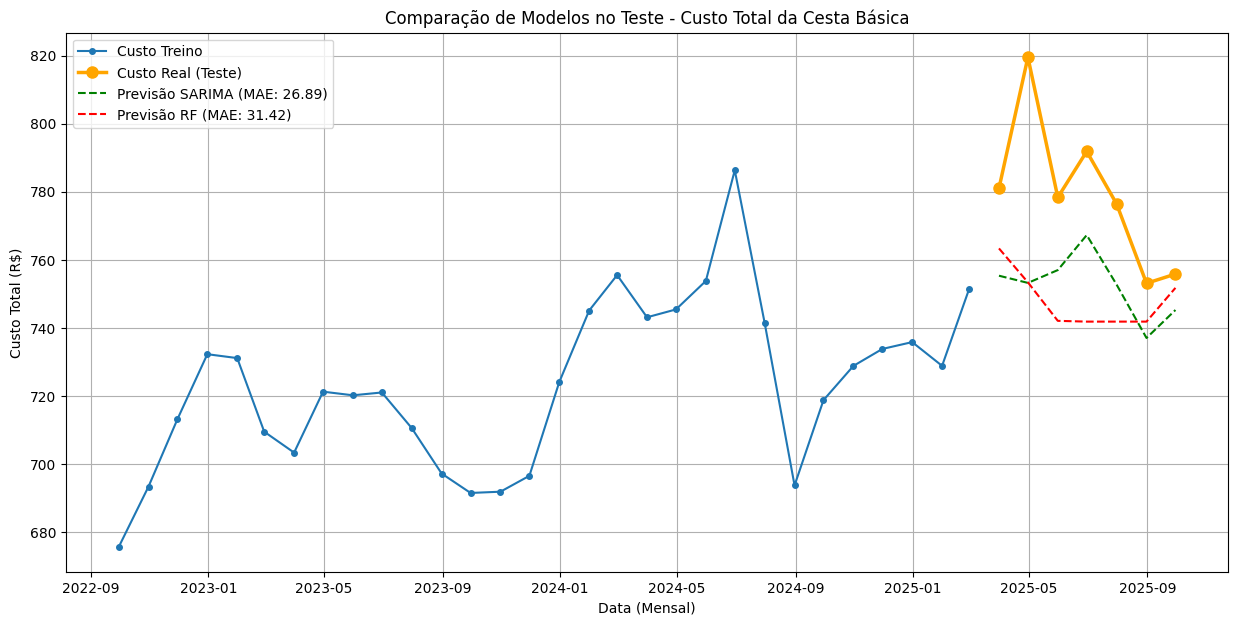

In [228]:
# SARIMAX
# Usaremos (1,d,1) e (1,0,0,12) como parâmetros robustos
modelo_sarima_cesta = SARIMAX(
    serie_train_cesta,
    order=(1, DIFERENCIACAO_CESTA, 1),
    seasonal_order=(1, 0, 0, 12)
)
resultado_sarima_cesta = modelo_sarima_cesta.fit(disp=False)
sarima_preds_cesta = resultado_sarima_cesta.get_prediction(start=serie_test_cesta.index[0], end=serie_test_cesta.index[-1]).predicted_mean
mae_sarima_cesta = mean_absolute_error(serie_test_cesta, sarima_preds_cesta)
print(f"MAE SARIMAX: R$ {mae_sarima_cesta:.2f}")

# Random Forest
modelo_rf_cesta = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf_cesta.fit(X_train_cesta, y_train_cesta)
rf_preds_cesta = modelo_rf_cesta.predict(X_test_cesta)
mae_rf_cesta = mean_absolute_error(y_test_cesta, rf_preds_cesta)
print(f"MAE Random Forest: R$ {mae_rf_cesta:.2f}")

# Seleção do Melhor Modelo
if mae_sarima_cesta < mae_rf_cesta:
    melhor_modelo_cesta_nome = 'SARIMA'
    melhor_modelo_cesta = resultado_sarima_cesta
    print(f"\n🏆 Melhor modelo para Cesta: SARIMA (MAE: R$ {mae_sarima_cesta:.2f})")
else:
    melhor_modelo_cesta_nome = 'RandomForest'
    melhor_modelo_cesta = modelo_rf_cesta
    print(f"\n🏆 Melhor modelo para Cesta: RandomForest (MAE: R$ {mae_rf_cesta:.2f})")

# Plotar as previsões de teste
plt.figure(figsize=(15, 7))
plt.plot(serie_train_cesta.index, serie_train_cesta, label='Custo Treino', marker='o', markersize=4)
plt.plot(serie_test_cesta.index, serie_test_cesta, label='Custo Real (Teste)', color='orange', linewidth=2.5, markersize=8, marker='o')
plt.plot(serie_test_cesta.index, sarima_preds_cesta, label=f'Previsão SARIMA (MAE: {mae_sarima_cesta:.2f})', color='green', linestyle='--')
plt.plot(serie_test_cesta.index, rf_preds_cesta, label=f'Previsão RF (MAE: {mae_rf_cesta:.2f})', color='red', linestyle='--')
plt.title(f"Comparação de Modelos no Teste - Custo Total da Cesta Básica")
plt.xlabel('Data (Mensal)')
plt.ylabel('Custo Total (R$)')
plt.legend()
plt.grid(True)
plt.show()

### **Passo 4: Treinamento Final e Previsão (12 Meses)**

Esta célula executa o passo final para responder à nossa Questão. Ela pega o **melhor modelo** (`melhor_modelo_cesta_nome`) que foi identificado na célula de avaliação anterior e o **retreina usando 100% dos dados** (o conjunto de treino + teste).

Com este modelo final, ele faz a **previsão para os próximos 12 meses**, respondendo à pergunta "quanto custará ano que vem?".

**Justificativa Metodológica:**

1.  **Por que Retreinar?** A divisão treino/teste  serviu *apenas* para **avaliar e selecionar** o melhor algoritmo (SARIMAX vs. RF). Agora que sabemos qual é o melhor (`melhor_modelo_cesta_nome`), não faz sentido jogar 20% dos nossos dados (o conjunto de teste) fora. Para fazer a previsão futura mais precisa, nós **retreinamos** o algoritmo vencedor com **todos os 37 meses** de dados históricos, dando a ele o máximo de informação possível.
2.  **Como a Previsão é Feita (SARIMAX vs. RF):**
    * Sendo o `SARIMAX` foi o vencedor, o modelo usa sua matemática interna para projetar 12 passos no futuro (`get_forecast(steps=12)`).
3.  **Avaliação:** Os `print`s no final da célula nos dão os valores exatos (Custo Atual vs. Custo Previsto) que usaremos na nossa seção "D. Conclusão" para discutir o impacto da inflação na cesta básica.

In [229]:
print(f"Previsão Futura (12 Meses) com o Modelo Vencedor ({melhor_modelo_cesta_nome})")

# Número de meses para prever
meses_para_prever = 12

# Lógica de Previsão
if melhor_modelo_cesta_nome == 'SARIMA':
    # Retreinar o SARIMA no dataset completo
    modelo_final_cesta = SARIMAX(
        serie_cesta_total,
        order=(1, DIFERENCIACAO_CESTA, 1),
        seasonal_order=(1, 0, 0, 12)
    )
    resultado_final_cesta = modelo_final_cesta.fit(disp=False)

    # Faz a previsão para 12 períodos
    forecast = resultado_final_cesta.get_forecast(steps=meses_para_prever)
    previsoes_futuras_cesta = forecast.predicted_mean

else:
    # Se for Random Forest, retreinamos com X e y completos
    modelo_final_cesta = RandomForestRegressor(n_estimators=100, random_state=42)
    modelo_final_cesta.fit(X_cesta, y_cesta)

    # Previsão Recursiva
    previsoes_futuras_lista = []
    ultimas_features = X_cesta.iloc[-1:].values

    for i in range(meses_para_prever):
        previsao = modelo_final_cesta.predict(ultimas_features)[0]
        previsoes_futuras_lista.append(previsao)

        # Atualizar features para a próxima iteração
        features_novas_array = np.roll(ultimas_features[0], 1)
        features_novas_array[0] = previsao
        features_novas_array[3] = (features_novas_array[0] + features_novas_array[1] + features_novas_array[2]) / 3
        ultimas_features = np.array([features_novas_array])

    # Criar um índice de datas para a previsão
    indice_previsao = pd.date_range(start=serie_cesta_total.index[-1] + pd.DateOffset(months=1), periods=meses_para_prever, freq='M')
    previsoes_futuras_cesta = pd.Series(previsoes_futuras_lista, index=indice_previsao, name="Previsao")

print(f"\n--- Previsões para os próximos {meses_para_prever} meses ---")
print(previsoes_futuras_cesta)

# Comparar Custo Atual vs. Ano que Vem
ultimo_custo_real = serie_cesta_total.iloc[-1]
ultimo_custo_previsto = previsoes_futuras_cesta.iloc[-1]
variacao_abs = ultimo_custo_previsto - ultimo_custo_real
variacao_perc = (variacao_abs / ultimo_custo_real) * 100

print("\n--- Comparação Custo Atual vs. Previsão para 1 Ano ---")
print(f"Custo Atual da Cesta (Mês de {serie_cesta_total.index[-1].strftime('%Y-%m')}): R$ {ultimo_custo_real:.2f}")
print(f"Previsão para daqui a 1 Ano ({previsoes_futuras_cesta.index[-1].strftime('%Y-%m')}): R$ {ultimo_custo_previsto:.2f}")
print(f"Variação estimada em 12 meses: R$ {variacao_abs:.2f} ({variacao_perc:+.2f}%)")

Previsão Futura (12 Meses) com o Modelo Vencedor (SARIMA)

--- Previsões para os próximos 12 meses ---
2025-10-31    756.787674
2025-11-30    759.328827
2025-12-31    759.570799
2026-01-31    757.514448
2026-02-28    764.631512
2026-03-31    774.111262
2026-04-30    786.376714
2026-05-31    773.247737
2026-06-30    777.555904
2026-07-31    772.633764
2026-08-31    765.198535
2026-09-30    766.064671
Freq: ME, Name: predicted_mean, dtype: float64

--- Comparação Custo Atual vs. Previsão para 1 Ano ---
Custo Atual da Cesta (Mês de 2025-09): R$ 755.84
Previsão para daqui a 1 Ano (2026-09): R$ 766.06
Variação estimada em 12 meses: R$ 10.23 (+1.35%)


### **Passo 5: Visualização da Previsão Final e Conclusão**

Plotamos os dados históricos do custo da cesta básica (`serie_cesta_total`) e, em seguida, plota a **previsão de 12 meses** (`previsoes_futuras_cesta`) que foi gerada pelo nosso modelo vencedor (`melhor_modelo_cesta_nome`).

**Justificativa Metodológica:**
Este gráfico é a **Conclusão** visual da questão

* **Respondendo à Questão A:** Nos deu os *números*, este gráfico traduz esses números em uma visualização clara e acionável, respondendo "quanto custará ano que vem?".
* **Atingindo o Objetivo (Extensão):** Este gráfico é o produto final da nossa extensão. Ele permite que qualquer pessoa possa ver de forma imediata:
    1.  O comportamento histórico do custo da cesta (linha azul).
    2.  O exato momento em que a previsão começa (a linha vertical pontilhada).
    3.  A trajetória futura (tendência de alta, baixa ou estabilidade) prevista pelo modelo mais preciso que encontramos (linha vermelha).
* **Conclusão:**  Tirada deste gráfico é que o modelo SARIMA prevê uma tendência de aumento no custo da cesta básica a curto prazo, nos meses seguintes ao "Início da Previsão".

Curto Prazo (Próximos 6 meses): O modelo projeta uma subida, saindo do último ponto histórico (cerca de 753 reais ) e atingindo um novo pico em algum momento no primeiro semestre de 2026, próximo de 790 reais.

Médio Prazo (Meados de 2026 em diante): Após atingir esse pico, a previsão sugere um período de leve queda e estabilização, mas ainda mantendo o custo em um patamar elevado (acima de R$ 760), sem retornar aos níveis mais baixos vistos em 2023.

Em resumo, a análise sugere que, com base nos padrões históricos de alta volatilidade e sazonalidade, a expectativa é de novas altas no preço da cesta básica nos próximos meses, antes de uma possível estabilização na segunda metade de 2026.


Gerando Gráfico Final da Previsão (12 Meses)


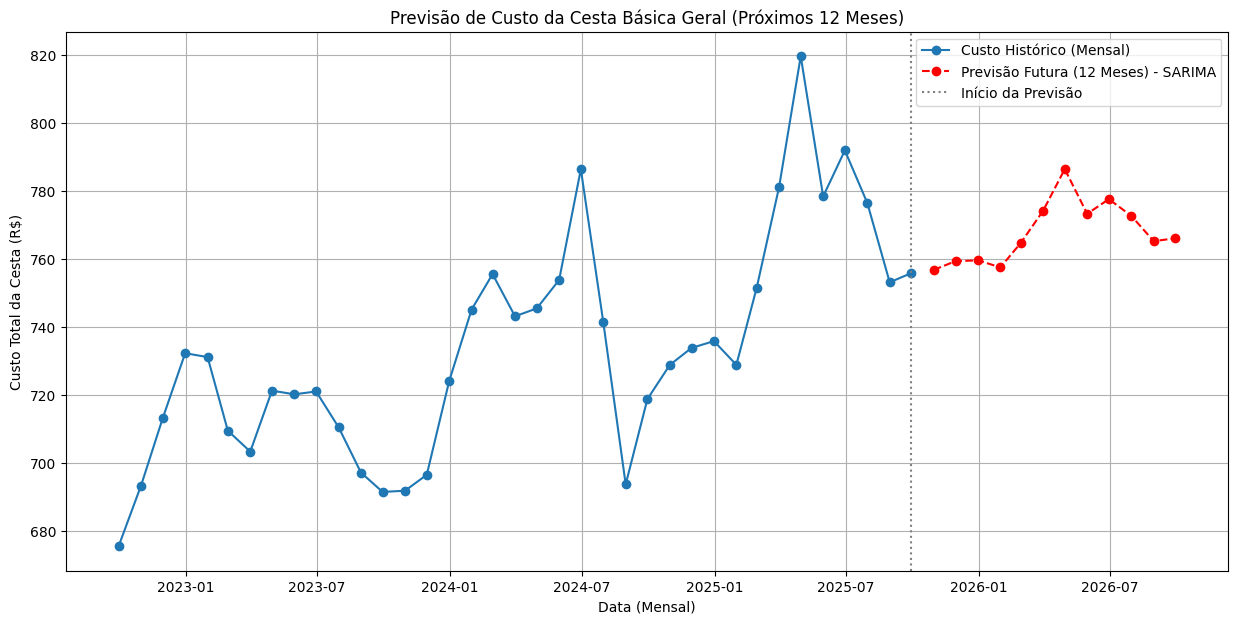

In [230]:
print("Gerando Gráfico Final da Previsão (12 Meses)")

plt.figure(figsize=(15, 7))

# Dados históricos
plt.plot(serie_cesta_total.index, serie_cesta_total, label='Custo Histórico (Mensal)', marker='o')

# Previsão futura de 12 meses
plt.plot(previsoes_futuras_cesta.index, previsoes_futuras_cesta, label=f'Previsão Futura (12 Meses) - {melhor_modelo_cesta_nome}',
         color='red', linestyle='--', marker='o', markersize=6)

# Linha vertical para separar o histórico da previsão
plt.axvline(serie_cesta_total.index[-1], color='gray', linestyle=':', label='Início da Previsão')

plt.title(f'Previsão de Custo da Cesta Básica Geral (Próximos 12 Meses)')
plt.xlabel('Data (Mensal)')
plt.ylabel('Custo Total da Cesta (R$)')
plt.legend()
plt.grid(True)
plt.show()